# ============================================================================
# TALLER 1 - PREDICCIÓN DE DEMANDA DE BICICLETAS COMPARTIDAS
# Parte 1: Ingeniería de Características y Exploración 
# ============================================================================


In [808]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression , Lasso, Ridge , ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


# ============================================================================
# 1a) DIVISIÓN DE DATOS EN TRAIN/VALIDATION/TEST 
# ============================================================================


In [809]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Cargar datos
data = pd.read_csv('bike_sharing_data.csv')

# Crear columna datetime combinando dteday y hr
data['dteday'] = pd.to_datetime(data['dteday'])
data['datetime'] = data['dteday'] + pd.to_timedelta(data['hr'], unit='h')

# Extraer el día del mes para la división
data['day'] = data['dteday'].dt.day

print(f"\nPrimeras filas del dataset:")
print(data.head())

# División temporal según especificaciones
train = data[data['day'] <= 14].copy()
validation = data[(data['day'] >= 15) & (data['day'] <= 21)].copy()
test = data[data['day'] >= 22].copy()

print(f"\nDIVISIÓN DE DATOS:")
print(f"   Train:      días 1-14  → {len(train):,} registros ({len(train)/len(data)*100:.1f}%)")
print(f"   Validation: días 15-21 → {len(validation):,} registros ({len(validation)/len(data)*100:.1f}%)")
print(f"   Test:       días 22+   → {len(test):,} registros ({len(test)/len(data)*100:.1f}%)")



Primeras filas del dataset:
   instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   
3           1  0.24  0.2879  0.75        0.0       3          10   13   
4           1  0.24  0.2879  0.75        0.0       0           1    1   

             datetime  day  
0 2011-01-01 00:00:00    1  
1 2011-01-0

# ============================================================================
# 1b) EXTRACCIÓN DE CARACTERÍSTICAS TEMPORALES
# ============================================================================


In [810]:
## Extraccion de Caracteristicas temporales
def extract_temporal_features(df):

    df['hour'] = df['hr']
    df['dayofweek'] = df['weekday']  
    df['month'] = df['mnth']
    df['year'] = df['yr']
    
    # Variables derivadas
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    
    # Categorización de horas del día
    df['hour_category'] = pd.cut(
        df['hr'], 
        bins=[-1, 5, 11, 17, 23],
        labels=['Madrugada', 'Mañana', 'Tarde', 'Noche']
    )
    
    # Hora pico: 7-9 AM y 5-7 PM en días laborales
    df['is_rush_hour'] = (
        (df['hr'].between(7, 9) | df['hr'].between(17, 19)) & 
        (df['workingday'] == 1)
    ).astype(int)
    
    return df


In [811]:
# Aplicar extracción a todos los conjuntos
train = extract_temporal_features(train)
validation = extract_temporal_features(validation)
test = extract_temporal_features(test)

print("\n Características temporales creadas:")
print("   • hour (0-23) - desde 'hr'")
print("   • dayofweek (0=Lun, 6=Dom) - desde 'weekday'")
print("   • month (1-12) - desde 'mnth'")
print("   • year - desde 'yr'")
print("   • is_weekend (binaria)")
print("   • hour_category (categórica: 4 niveles)")
print("   • is_rush_hour (binaria)")

# Mostrar ejemplo de las nuevas características
print("\n Muestra de características temporales:")
temporal_cols = ['datetime', 'hour', 'dayofweek', 'month', 'is_weekend', 
                 'hour_category', 'is_rush_hour', 'workingday']
print(train[temporal_cols].head(10))


 Características temporales creadas:
   • hour (0-23) - desde 'hr'
   • dayofweek (0=Lun, 6=Dom) - desde 'weekday'
   • month (1-12) - desde 'mnth'
   • year - desde 'yr'
   • is_weekend (binaria)
   • hour_category (categórica: 4 niveles)
   • is_rush_hour (binaria)

 Muestra de características temporales:
             datetime  hour  dayofweek  month  is_weekend hour_category  \
0 2011-01-01 00:00:00     0          6      1           1     Madrugada   
1 2011-01-01 01:00:00     1          6      1           1     Madrugada   
2 2011-01-01 02:00:00     2          6      1           1     Madrugada   
3 2011-01-01 03:00:00     3          6      1           1     Madrugada   
4 2011-01-01 04:00:00     4          6      1           1     Madrugada   
5 2011-01-01 05:00:00     5          6      1           1     Madrugada   
6 2011-01-01 06:00:00     6          6      1           1        Mañana   
7 2011-01-01 07:00:00     7          6      1           1        Mañana   
8 2011-01-01 08

# ============================================================================
# 1c) ANÁLISIS EXPLORATORIO 
# ============================================================================


In [812]:
#Analisis exploratorio de datos (EDA)

# Usar 'cnt' como la variable objetivo (count)
stats_cols = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 
              'hum', 'windspeed', 'casual', 'registered', 'cnt']

print(train[stats_cols].describe().round(2))


print("\n Información de variables categóricas:")
categorical_info = {
    'season': train['season'].value_counts().sort_index(),
    'weathersit': train['weathersit'].value_counts().sort_index(),
    'holiday': train['holiday'].value_counts(),
    'workingday': train['workingday'].value_counts()
}
for var, counts in categorical_info.items():
    print(f"\n{var}:")
    print(counts)



        season  holiday  workingday  weathersit     temp    atemp      hum  \
count  8026.00  8026.00     8026.00     8026.00  8026.00  8026.00  8026.00   
mean      2.51     0.03        0.69        1.41     0.49     0.47     0.62   
std       1.12     0.16        0.46        0.64     0.20     0.18     0.20   
min       1.00     0.00        0.00        1.00     0.02     0.02     0.00   
25%       2.00     0.00        0.00        1.00     0.34     0.33     0.46   
50%       3.00     0.00        1.00        1.00     0.48     0.47     0.61   
75%       4.00     0.00        1.00        2.00     0.66     0.62     0.78   
max       4.00     1.00        1.00        4.00     1.00     0.91     1.00   

       windspeed   casual  registered      cnt  
count    8026.00  8026.00     8026.00  8026.00  
mean        0.19    35.34      154.40   189.74  
std         0.12    48.93      150.94   180.28  
min         0.00     0.00        0.00     1.00  
25%         0.10     4.00       35.00    41.00  
50%


📈 Generando matriz de correlación...


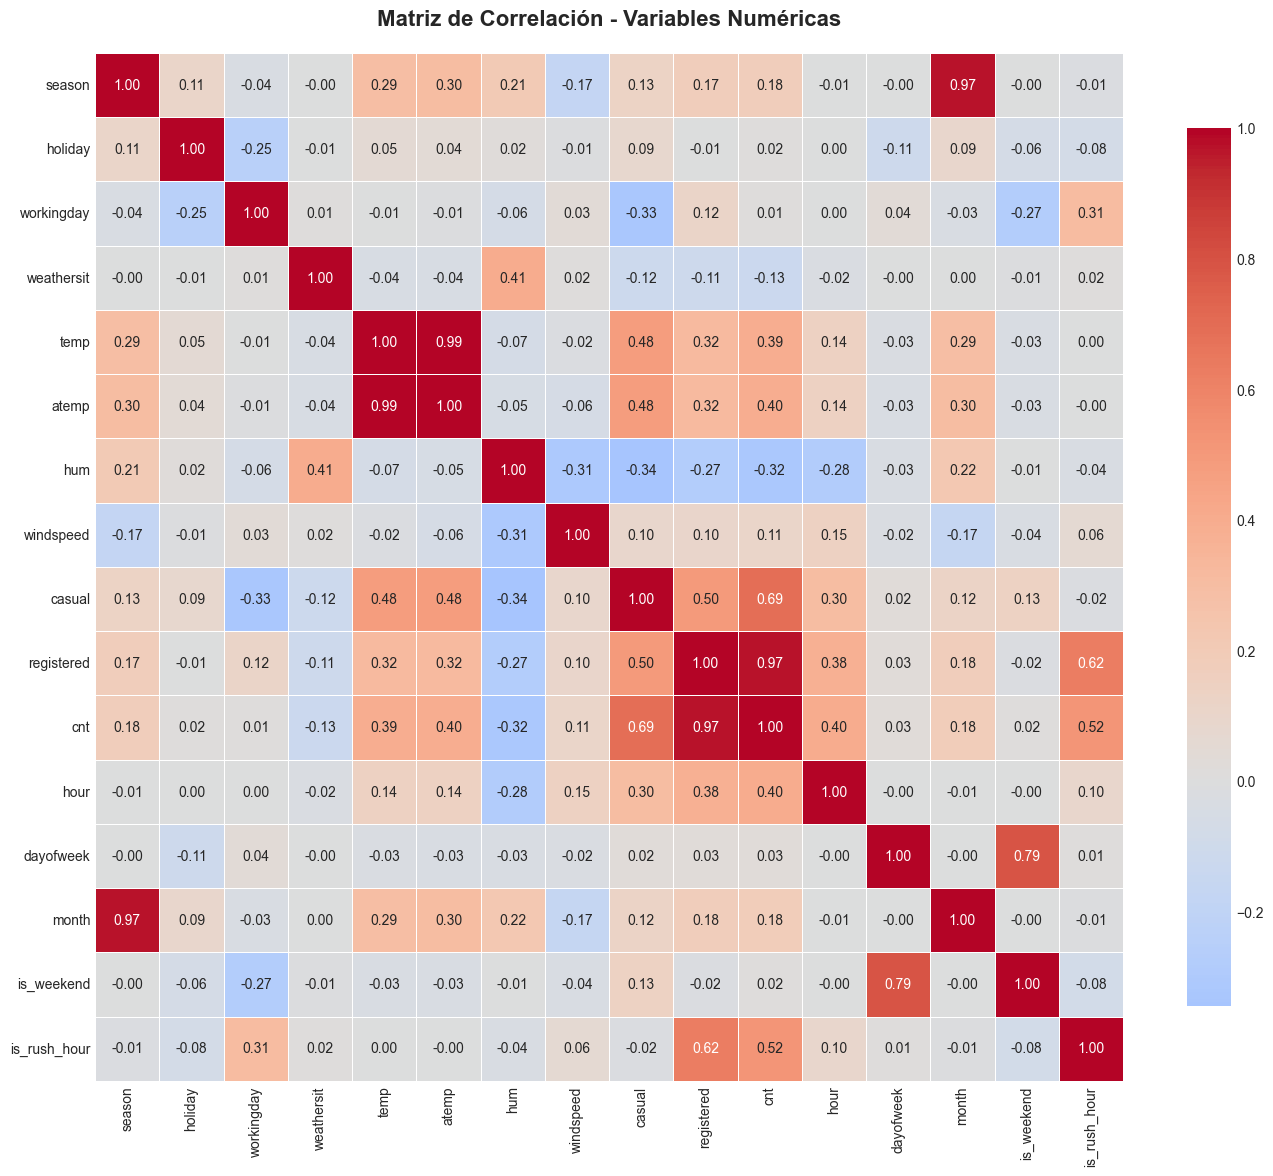

   ✅ Matriz de correlación guardada: 01_correlation_matrix.png

🎯 TOP 10 Correlaciones con 'cnt' (variable objetivo):
   registered     : 0.972
   casual         : 0.687
   is_rush_hour   : 0.518
   hour           : 0.400
   atemp          : 0.395
   temp           : 0.395
   hum            : 0.322
   month          : 0.183
   season         : 0.180
   weathersit     : 0.126


In [ ]:
# --- Matriz de Correlación ---
print("\n📈 Generando matriz de correlación...")
numeric_cols = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 
                'hum', 'windspeed', 'casual', 'registered', 'cnt',
                'hour', 'dayofweek', 'month', 'is_weekend', 'is_rush_hour']

corr_matrix = train[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


# Correlaciones más fuertes con 'cnt'
print("\n🎯 TOP 10 Correlaciones con 'cnt' (variable objetivo):")
count_corr = corr_matrix['cnt'].abs().sort_values(ascending=False)[1:11]
for var, corr in count_corr.items():
    print(f"   {var:15s}: {corr:.3f}")

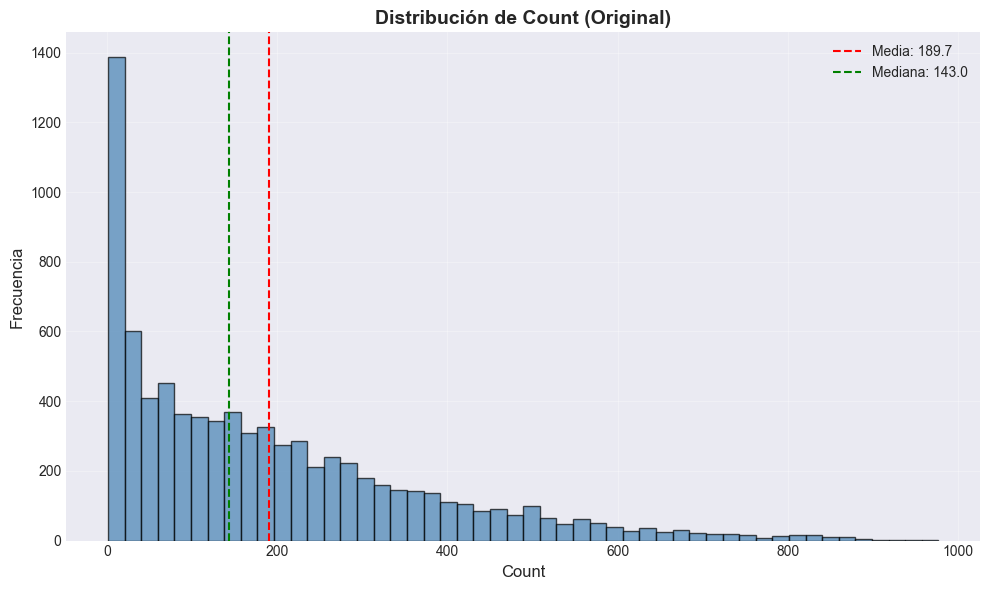

In [814]:
# 1. Histograma de count original
plt.figure(figsize=(10, 6))
plt.hist(train['cnt'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Count (Original)', fontsize=14, fontweight='bold')
plt.axvline(train['cnt'].mean(), color='red', linestyle='--', label=f'Media: {train["cnt"].mean():.1f}')
plt.axvline(train['cnt'].median(), color='green', linestyle='--', label=f'Mediana: {train["cnt"].median():.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

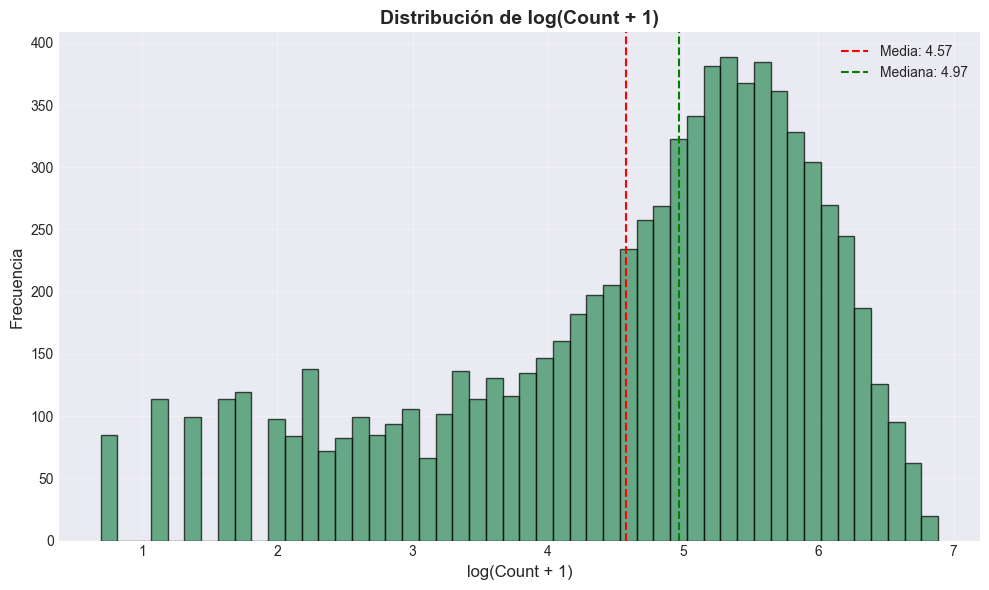

In [815]:
# 2. Histograma de log(count+1)
plt.figure(figsize=(10, 6))
log_count = np.log1p(train['cnt']) 
plt.hist(log_count, bins=50, edgecolor='black', alpha=0.7, color='seagreen')
plt.xlabel('log(Count + 1)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de log(Count + 1)', fontsize=14, fontweight='bold')
plt.axvline(log_count.mean(), color='red', linestyle='--', label=f'Media: {log_count.mean():.2f}')
plt.axvline(log_count.median(), color='green', linestyle='--', label=f'Mediana: {log_count.median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

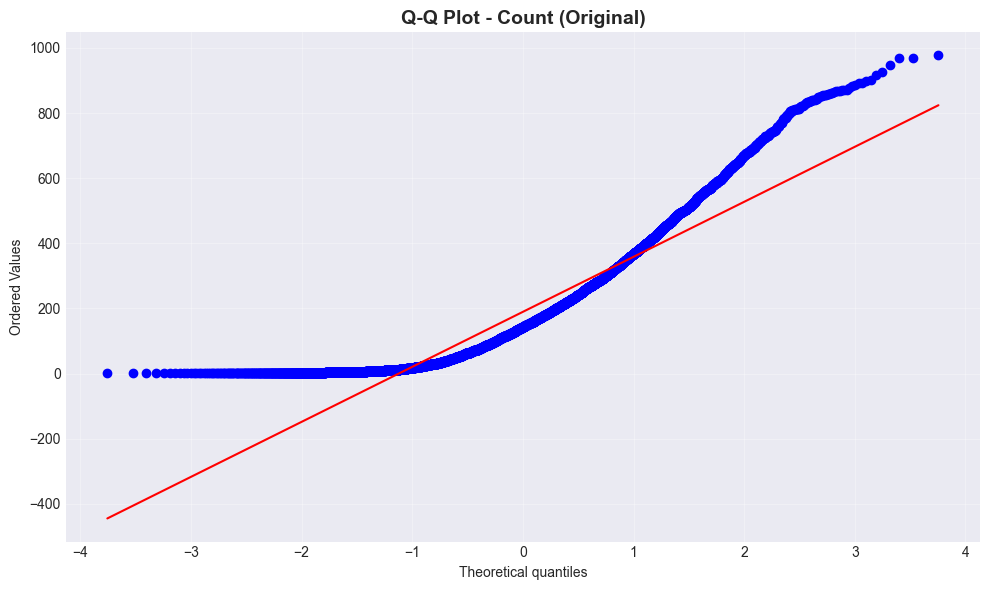

In [816]:
# 3. Q-Q Plot para count original
plt.figure(figsize=(10, 6))
stats.probplot(train['cnt'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Count (Original)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


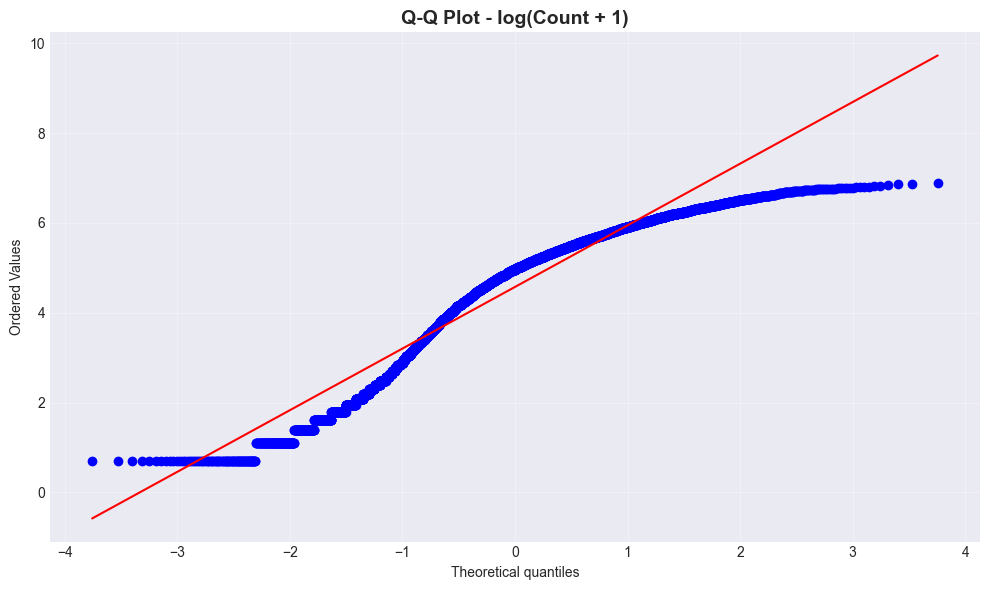

In [817]:
# 4. Q-Q Plot para log(count+1)
plt.figure(figsize=(10, 6))
stats.probplot(log_count, dist="norm", plot=plt)  # 
plt.title('Q-Q Plot - log(Count + 1)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


1. Demanda promedio por hora del día...


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

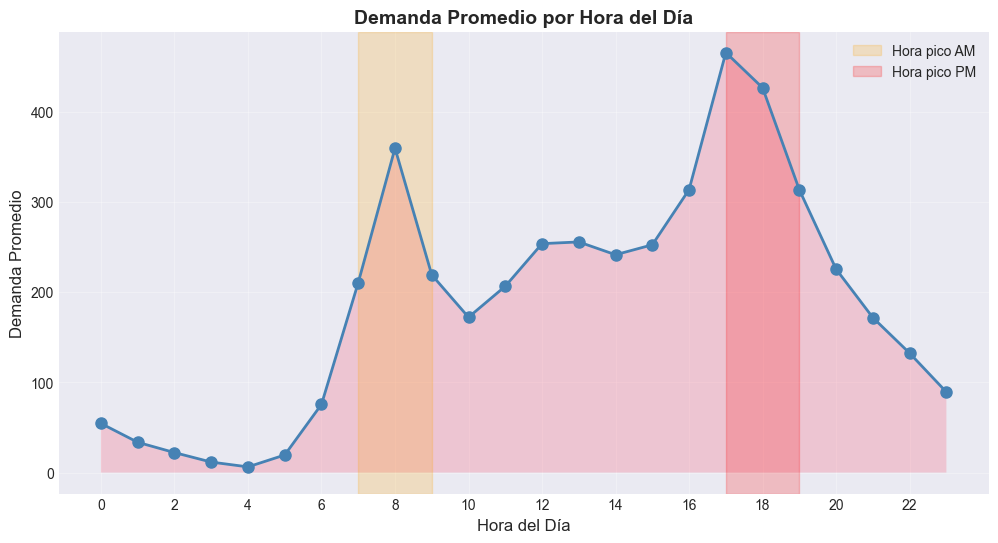

In [818]:
# --- 4 Visualizaciones Clave por Separado ---

# 1. Demanda promedio por hora del día
print("1. Demanda promedio por hora del día...")
plt.figure(figsize=(12, 6))
hourly_demand = train.groupby('hour')['cnt'].mean()
plt.plot(hourly_demand.index, hourly_demand.values, marker='o', 
         linewidth=2, markersize=8, color='steelblue')
plt.fill_between(hourly_demand.index, hourly_demand.values, alpha=0.3)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Demanda Promedio', fontsize=12)
plt.title('Demanda Promedio por Hora del Día', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.axvspan(7, 9, alpha=0.2, color='orange', label='Hora pico AM')
plt.axvspan(17, 19, alpha=0.2, color='red', label='Hora pico PM')
plt.legend()
plt.tight_layout

2. Demanda promedio por día de la semana...


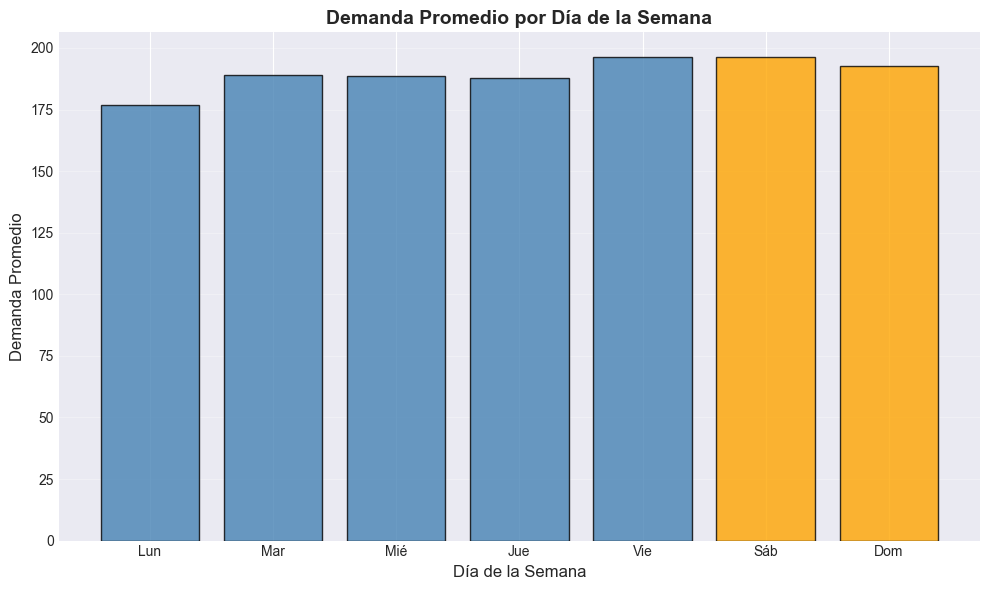

In [819]:
# 2. Demanda por día de la semana
print("2. Demanda promedio por día de la semana...")
plt.figure(figsize=(10, 6))
dow_demand = train.groupby('dayofweek')['cnt'].mean()
days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
colors_dow = ['steelblue' if i < 5 else 'orange' for i in range(7)]
plt.bar(range(7), dow_demand.values, color=colors_dow, edgecolor='black', alpha=0.8)
plt.xticks(range(7), days)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Demanda Promedio', fontsize=12)
plt.title('Demanda Promedio por Día de la Semana', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


3. Relación entre temperatura y demanda...


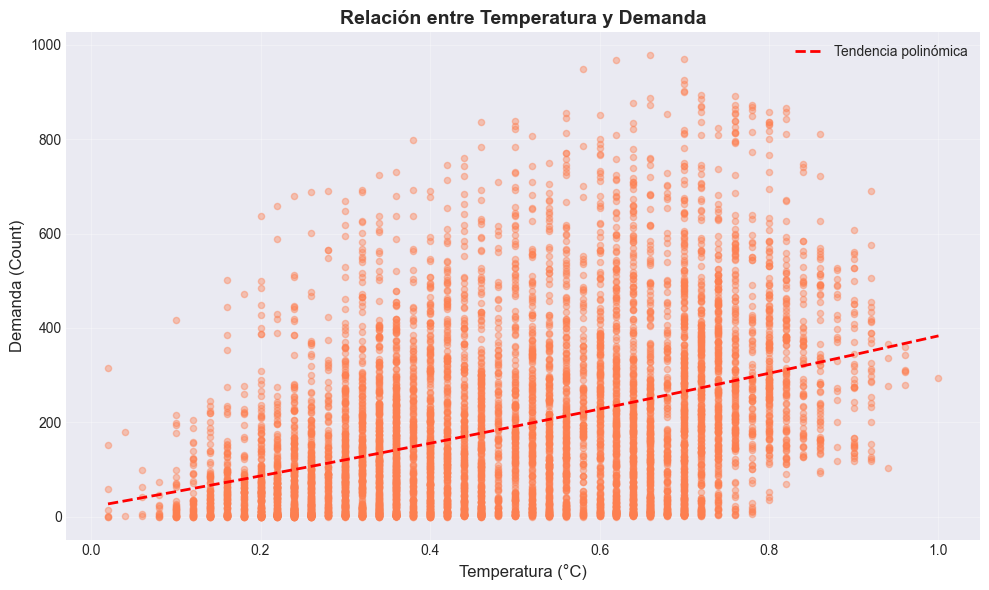

In [820]:
# 3. Relación temperatura vs demanda
print("3. Relación entre temperatura y demanda...")
plt.figure(figsize=(10, 6))
plt.scatter(train['temp'], train['cnt'], alpha=0.4, s=20, color='coral')
z = np.polyfit(train['temp'], train['cnt'], 2)
p = np.poly1d(z)
temp_sorted = np.sort(train['temp'])
plt.plot(temp_sorted, p(temp_sorted), "r--", linewidth=2, label='Tendencia polinómica')
plt.xlabel('Temperatura (°C)', fontsize=12)
plt.ylabel('Demanda (Count)', fontsize=12)
plt.title('Relación entre Temperatura y Demanda', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

4. Distribución de demanda por condición climática...


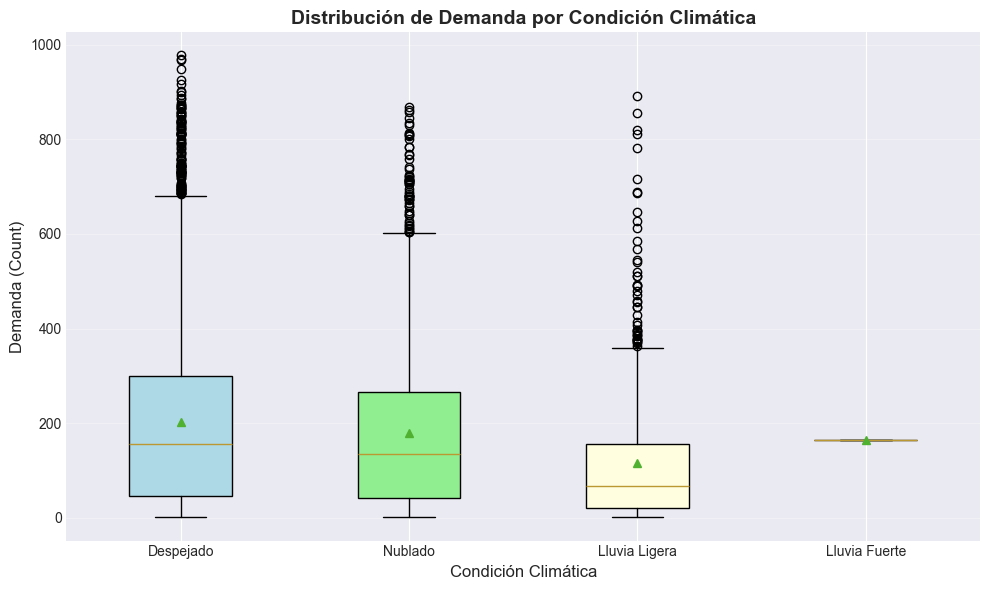

In [821]:
# 4. Boxplot por condición climática
print("4. Distribución de demanda por condición climática...")
plt.figure(figsize=(10, 6))
weather_labels = {1: 'Despejado', 2: 'Nublado', 3: 'Lluvia Ligera', 4: 'Lluvia Fuerte'}
train['weather_label'] = train['weathersit'].map(weather_labels)
box_data = [train[train['weathersit'] == i]['cnt'].values for i in sorted(train['weathersit'].unique())]
bp = plt.boxplot(box_data, labels=[weather_labels.get(i, str(i)) for i in sorted(train['weathersit'].unique())],
                 patch_artist=True, showmeans=True)
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
plt.xlabel('Condición Climática', fontsize=12)
plt.ylabel('Demanda (Count)', fontsize=12)
plt.title('Distribución de Demanda por Condición Climática', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [822]:
#1D preparacion de datos

# --- Identificar valores faltantes ---
print("\nANÁLISIS DE VALORES FALTANTES:")
missing_train = train.isnull().sum()
missing_train_pct = (missing_train / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Variable': missing_train.index,
    'Valores Faltantes': missing_train.values,
    'Porcentaje': missing_train_pct.values
})
missing_df = missing_df[missing_df['Valores Faltantes'] > 0]

if len(missing_df) == 0:
    print("   ✅ No se encontraron valores faltantes en el conjunto de entrenamiento")
else:
    print(missing_df)



ANÁLISIS DE VALORES FALTANTES:
   ✅ No se encontraron valores faltantes en el conjunto de entrenamiento


In [823]:
# --- Identificar valores anómalos ---
print("\nANÁLISIS DE VALORES ANÓMALOS:")
print("\nRango de valores para variables numéricas:")
numeric_check = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
for col in numeric_check:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
    print(f"   {col:12s}: Min={train[col].min():7.2f}, Max={train[col].max():7.2f}, "
          f"Outliers={outliers} ({outliers/len(train)*100:.1f}%)")



ANÁLISIS DE VALORES ANÓMALOS:

Rango de valores para variables numéricas:
   temp        : Min=   0.02, Max=   1.00, Outliers=0 (0.0%)
   atemp       : Min=   0.02, Max=   0.91, Outliers=0 (0.0%)
   hum         : Min=   0.00, Max=   1.00, Outliers=0 (0.0%)
   windspeed   : Min=   0.00, Max=   0.85, Outliers=167 (2.1%)
   cnt         : Min=   1.00, Max= 977.00, Outliers=219 (2.7%)


In [824]:
# --- Transformación logarítmica ---
print("\n APLICANDO TRANSFORMACIÓN LOGARÍTMICA:")
print("   Fórmula: log_count = log(cnt + 1)")

train['log_count'] = np.log1p(train['cnt'])
validation['log_count'] = np.log1p(validation['cnt'])
test['log_count'] = np.log1p(test['cnt'])

print(f"   Variable objetivo transformada creada: 'log_count'")
print(f"\n   Estadísticas de log_count (train):")
print(f"      Media:    {train['log_count'].mean():.4f}")
print(f"      Mediana:  {train['log_count'].median():.4f}")
print(f"      Std:      {train['log_count'].std():.4f}")
print(f"      Min:      {train['log_count'].min():.4f}")
print(f"      Max:      {train['log_count'].max():.4f}")



 APLICANDO TRANSFORMACIÓN LOGARÍTMICA:
   Fórmula: log_count = log(cnt + 1)
   Variable objetivo transformada creada: 'log_count'

   Estadísticas de log_count (train):
      Media:    4.5747
      Mediana:  4.9698
      Std:      1.4277
      Min:      0.6931
      Max:      6.8855


In [825]:
# --- Normalización de variables numéricas ---
print("\n🔄 NORMALIZACIÓN DE VARIABLES NUMÉRICAS:")
print("   Método: StandardScaler (media=0, std=1)")

numeric_features_to_scale = ['hour', 'month', 'dayofweek']

print(f"   Variables a normalizar: {numeric_features_to_scale}")
print(f"   Nota: temp, atemp, hum, windspeed ya vienen normalizados (0-1) en el dataset")

# IMPORTANTE: Ajustar scaler SOLO con datos de entrenamiento
scaler = StandardScaler()
train[numeric_features_to_scale] = scaler.fit_transform(train[numeric_features_to_scale])
validation[numeric_features_to_scale] = scaler.transform(validation[numeric_features_to_scale])
test[numeric_features_to_scale] = scaler.transform(test[numeric_features_to_scale])

print("\n   ✅ Normalización completada")
print("   ⚠️  Scaler ajustado SOLO con datos de train y aplicado a validation/test")

print("\n   Verificación de normalización (train):")
for col in numeric_features_to_scale:
    print(f"      {col:12s}: Media={train[col].mean():7.4f}, Std={train[col].std():7.4f}")



🔄 NORMALIZACIÓN DE VARIABLES NUMÉRICAS:
   Método: StandardScaler (media=0, std=1)
   Variables a normalizar: ['hour', 'month', 'dayofweek']
   Nota: temp, atemp, hum, windspeed ya vienen normalizados (0-1) en el dataset

   ✅ Normalización completada
   ⚠️  Scaler ajustado SOLO con datos de train y aplicado a validation/test

   Verificación de normalización (train):
      hour        : Media= 0.0000, Std= 1.0001
      month       : Media= 0.0000, Std= 1.0001
      dayofweek   : Media=-0.0000, Std= 1.0001


In [826]:
# --- Preparar características finales ---
print("\n PREPARACIÓN DE CONJUNTOS DE CARACTERÍSTICAS:")

# Variables originales para modelo base (usar nombres correctos)
original_features = ['season', 'holiday', 'workingday', 'weathersit', 
                     'temp', 'atemp', 'hum', 'windspeed']

# Características temporales adicionales
temporal_features = ['hour', 'dayofweek', 'month', 'year', 'is_weekend', 'is_rush_hour']

print(f"\n   Variables originales ({len(original_features)}): {original_features}")
print(f"\n   Características temporales ({len(temporal_features)}): {temporal_features}")

# Codificar hour_category (one-hot encoding)
train_encoded = pd.get_dummies(train, columns=['hour_category'], drop_first=False, dtype=int)
validation_encoded = pd.get_dummies(validation, columns=['hour_category'], drop_first=False, dtype=int)
test_encoded = pd.get_dummies(test, columns=['hour_category'], drop_first=False, dtype=int)

hour_cat_features = [col for col in train_encoded.columns if 'hour_category' in col]
print(f"\n   Variables categóricas codificadas ({len(hour_cat_features)}): {hour_cat_features}")


# Todas las características para modelo mejorado
all_features = original_features + temporal_features + hour_cat_features

print(f"\n    Total de características disponibles: {len(all_features)}")

# --- 



 PREPARACIÓN DE CONJUNTOS DE CARACTERÍSTICAS:

   Variables originales (8): ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

   Características temporales (6): ['hour', 'dayofweek', 'month', 'year', 'is_weekend', 'is_rush_hour']

   Variables categóricas codificadas (4): ['hour_category_Madrugada', 'hour_category_Mañana', 'hour_category_Tarde', 'hour_category_Noche']

    Total de características disponibles: 18


# ============================================================================
# 2a) MODELO INICIAL CON VARIABLES ORIGINALES 
# ============================================================================


In [827]:
# Variables originales (ajustadas a los nombres reales del dataset)

#Se elimino temp por problema de multicolinealidad
#Tambien por problema de analisis de coeficiente
#temp Coef = -2.5631 -> Efecto negativo de la temperatura en la demanda
#atemp Coef = 5.4451 -> Efecto positivo de la temperatura aparente en la demanda

#Se elimino hum por problema de multicolinealidad (severa)
#hum Coef = 10.76 
#Se elimina atempo por problema de multicolinealidad (moderada)
#atemp Coef = 6.62
#Si bien es relevante en otras areas, en EE.UU la temporada es acorde a la temperatura actual 

# Variables originales (ajustadas a los nombres reales del dataset)
original_features = ['season', 'holiday', 'workingday', 'weathersit', 
                     'temp', 'atemp', 'hum', 'windspeed']


# Preparar datos para el modelo
X_train = train[original_features]
y_train = train['log_count']

X_val = validation[original_features]
y_val = validation['log_count']


#Entrenar modelo de regresión lineal

model_base = LinearRegression()
model_base.fit(X_train, y_train)



#Predicciones
y_pred_train = model_base.predict(X_train)
y_pred_val = model_base.predict(X_val)

#Evaluacion en escala logarítmica
mse_log_train = mean_squared_error(y_train, y_pred_train)
rmse_log_train = np.sqrt(mse_log_train)
mae_log_train = mean_absolute_error(y_train, y_pred_train)
r2_log_train = r2_score(y_train, y_pred_train)

mse_log_val = mean_squared_error(y_val, y_pred_val)
rmse_log_val = np.sqrt(mse_log_val)
mae_log_val = mean_absolute_error(y_val, y_pred_val)
r2_log_val = r2_score(y_val, y_pred_val)

print("\n TRAIN:")
print(f"   MSE:  {mse_log_train:.4f}")
print(f"   RMSE: {rmse_log_train:.4f}")
print(f"   MAE:  {mae_log_train:.4f}")
print(f"   R²:   {r2_log_train:.4f}")

print("\n VALIDATION:")
print(f"   MSE:  {mse_log_val:.4f}")
print(f"   RMSE: {rmse_log_val:.4f}")
print(f"   MAE:  {mae_log_val:.4f}")
print(f"   R²:   {r2_log_val:.4f}")



 TRAIN:
   MSE:  1.4749
   RMSE: 1.2144
   MAE:  0.9439
   R²:   0.2763

 VALIDATION:
   MSE:  1.5427
   RMSE: 1.2421
   MAE:  0.9764
   R²:   0.2168


In [828]:
# --- Evaluación en escala original ---


# Revertir transformación logarítmica
y_pred_train_original = np.expm1(y_pred_train)
y_train_original = train['cnt']

y_pred_val_original = np.expm1(y_pred_val)
y_val_original = validation['cnt']

mse_original_train = mean_squared_error(y_train_original, y_pred_train_original)
rmse_original_train = np.sqrt(mse_original_train)
mae_original_train = mean_absolute_error(y_train_original, y_pred_train_original)
r2_original_train = r2_score(y_train_original, y_pred_train_original)

mse_original_val = mean_squared_error(y_val_original, y_pred_val_original)
rmse_original_val = np.sqrt(mse_original_val)
mae_original_val = mean_absolute_error(y_val_original, y_pred_val_original)
r2_original_val = r2_score(y_val_original, y_pred_val_original)

print("\n TRAIN:")
print(f"   MSE:  {mse_original_train:.2f}")
print(f"   RMSE: {rmse_original_train:.2f} bicicletas")
print(f"   MAE:  {mae_original_train:.2f} bicicletas")
print(f"   R²:   {r2_original_train:.4f}")

print("\nVALIDATION:")
print(f"   MSE:  {mse_original_val:.2f}")
print(f"   RMSE: {rmse_original_val:.2f} bicicletas")
print(f"   MAE:  {mae_original_val:.2f} bicicletas")
print(f"   R²:   {r2_original_val:.4f}")





 TRAIN:
   MSE:  28640.34
   RMSE: 169.23 bicicletas
   MAE:  114.29 bicicletas
   R²:   0.1186

VALIDATION:
   MSE:  32275.11
   RMSE: 179.65 bicicletas
   MAE:  122.10 bicicletas
   R²:   0.0347


In [829]:
# --- Interpretar coeficientes ---

coef_df = pd.DataFrame({
    'Variable': original_features,
    'Coeficiente': model_base.coef_,
    'Abs_Coef': np.abs(model_base.coef_)
}).sort_values('Abs_Coef', ascending=False)

print(f"\nIntercepto: {model_base.intercept_:.4f}")
print("\nCoeficientes ordenados por importancia (valor absoluto):")
print(coef_df[['Variable', 'Coeficiente']].to_string(index=False))

print("\n💡 INTERPRETACIÓN DE LOS TOP 3 COEFICIENTES:")
for i, row in coef_df.head(3).iterrows():
    var = row['Variable']
    coef = row['Coeficiente']
    direction = "aumenta" if coef > 0 else "disminuye"
    print(f"\n   {var}:")
    print(f"   • Coeficiente: {coef:.4f}")
    print(f"   • Interpretación: Por cada unidad de aumento en {var},")
    print(f"     log(cnt) {direction} en {abs(coef):.4f} (manteniendo todo lo demás constante)")
    if coef > 0:
        print(f"    → Efecto POSITIVO en la demanda")
    else:
        print(f"     → Efecto NEGATIVO en la demanda")



Intercepto: 4.1471

Coeficientes ordenados por importancia (valor absoluto):
  Variable  Coeficiente
     atemp     5.445097
       hum    -2.665717
      temp    -2.563072
 windspeed     0.825305
    season     0.211847
workingday    -0.122810
weathersit     0.116573
   holiday    -0.077744

💡 INTERPRETACIÓN DE LOS TOP 3 COEFICIENTES:

   atemp:
   • Coeficiente: 5.4451
   • Interpretación: Por cada unidad de aumento en atemp,
     log(cnt) aumenta en 5.4451 (manteniendo todo lo demás constante)
    → Efecto POSITIVO en la demanda

   hum:
   • Coeficiente: -2.6657
   • Interpretación: Por cada unidad de aumento en hum,
     log(cnt) disminuye en 2.6657 (manteniendo todo lo demás constante)
     → Efecto NEGATIVO en la demanda

   temp:
   • Coeficiente: -2.5631
   • Interpretación: Por cada unidad de aumento en temp,
     log(cnt) disminuye en 2.5631 (manteniendo todo lo demás constante)
     → Efecto NEGATIVO en la demanda



######################################################
# 2b) MODELO MEJORADO CON TODAS LAS CARACTERÍSTICAS 
#######################################################

In [830]:
    
temporal_features = ['hour', 'dayofweek', 'month', 'year', 'is_weekend', 'is_rush_hour']

# Características de hour_category (one-hot encoded)
hour_cat_features = [col for col in train_encoded.columns if 'hour_category' in col]

# Todas las características
all_features = original_features + temporal_features + hour_cat_features




print(f"\n Características utilizadas ({len(all_features)}):")
print(f"   • Variables originales:        {len(original_features)}")
print(f"   • Características temporales:  {len(temporal_features)}")
print(f"   • Hour category (one-hot):     {len(hour_cat_features)}")
print(f"   • TOTAL:                       {len(all_features)}")

# Preparar datos
X_train_full = train_encoded[all_features]
y_train_full = train_encoded['log_count']

X_val_full = validation_encoded[all_features]
y_val_full = validation_encoded['log_count']

print(f"\n📊 Dimensiones:")
print(f"   X_train: {X_train_full.shape}")
print(f"   X_val:   {X_val_full.shape}")

# --- Entrenar modelo mejorado ---
model_improved = LinearRegression()
model_improved.fit(X_train_full, y_train_full)

# --- Predicciones ---
y_pred_train_improved = model_improved.predict(X_train_full)
y_pred_val_improved = model_improved.predict(X_val_full)



 Características utilizadas (18):
   • Variables originales:        8
   • Características temporales:  6
   • Hour category (one-hot):     4
   • TOTAL:                       18

📊 Dimensiones:
   X_train: (8026, 18)
   X_val:   (4008, 18)


In [831]:
# --- Evaluación ---

# Escala logarítmica
mse_log_val_improved = mean_squared_error(y_val_full, y_pred_val_improved)
rmse_log_val_improved = np.sqrt(mse_log_val_improved)
mae_log_val_improved = mean_absolute_error(y_val_full, y_pred_val_improved)
r2_log_val_improved = r2_score(y_val_full, y_pred_val_improved)

# Escala original
y_pred_val_improved_original = np.expm1(y_pred_val_improved)
y_val_full_original = validation_encoded['cnt']

rmse_original_val_improved = np.sqrt(mean_squared_error(y_val_full_original, y_pred_val_improved_original))
mae_original_val_improved = mean_absolute_error(y_val_full_original, y_pred_val_improved_original)
r2_original_val_improved = r2_score(y_val_full_original, y_pred_val_improved_original)

print("\n🎯 VALIDATION - Escala logarítmica:")
print(f"   RMSE: {rmse_log_val_improved:.4f}")
print(f"   MAE:  {mae_log_val_improved:.4f}")
print(f"   R²:   {r2_log_val_improved:.4f}")

print("\n🎯 VALIDATION - Escala original:")
print(f"   RMSE: {rmse_original_val_improved:.2f} bicicletas")
print(f"   MAE:  {mae_original_val_improved:.2f} bicicletas")
print(f"   R²:   {r2_original_val_improved:.4f}")



🎯 VALIDATION - Escala logarítmica:
   RMSE: 0.6661
   MAE:  0.4981
   R²:   0.7748

🎯 VALIDATION - Escala original:
   RMSE: 101.28 bicicletas
   MAE:  65.76 bicicletas
   R²:   0.6932


In [832]:
# --- Comparación entre modelos ---

print("COMPARACIÓN: MODELO BASE vs MODELO MEJORADO")


comparison_df = pd.DataFrame({
    'Métrica': ['RMSE (log)', 'MAE (log)', 'R²', 'RMSE (original)', 'MAE (original)'],
    'Modelo Base': [rmse_log_val, mae_log_val, r2_log_val, rmse_original_val, mae_original_val],
    'Modelo Mejorado': [rmse_log_val_improved, mae_log_val_improved, r2_log_val_improved, 
                        rmse_original_val_improved, mae_original_val_improved]
})

comparison_df['Mejora (%)'] = ((comparison_df['Modelo Base'] - comparison_df['Modelo Mejorado']) / 
                                comparison_df['Modelo Base'] * 100)

print("\n" + comparison_df.to_string(index=False))

print(f"\n RESUMEN:")
print(f"   • Reducción en RMSE (log):      {comparison_df.loc[0, 'Mejora (%)']:.2f}%")
print(f"   • Reducción en RMSE (original): {comparison_df.loc[3, 'Mejora (%)']:.2f}%")
print(f"   • Mejora en R²:                 {(r2_log_val_improved - r2_log_val):.4f}")



COMPARACIÓN: MODELO BASE vs MODELO MEJORADO

        Métrica  Modelo Base  Modelo Mejorado  Mejora (%)
     RMSE (log)     1.242066         0.666087   46.372649
      MAE (log)     0.976438         0.498056   48.992607
             R²     0.216832         0.774769 -257.313704
RMSE (original)   179.652754       101.275697   43.626972
 MAE (original)   122.095264        65.761094   46.139521

 RESUMEN:
   • Reducción en RMSE (log):      46.37%
   • Reducción en RMSE (original): 43.63%
   • Mejora en R²:                 0.5579



 Generando gráfico de importancia de coeficientes...


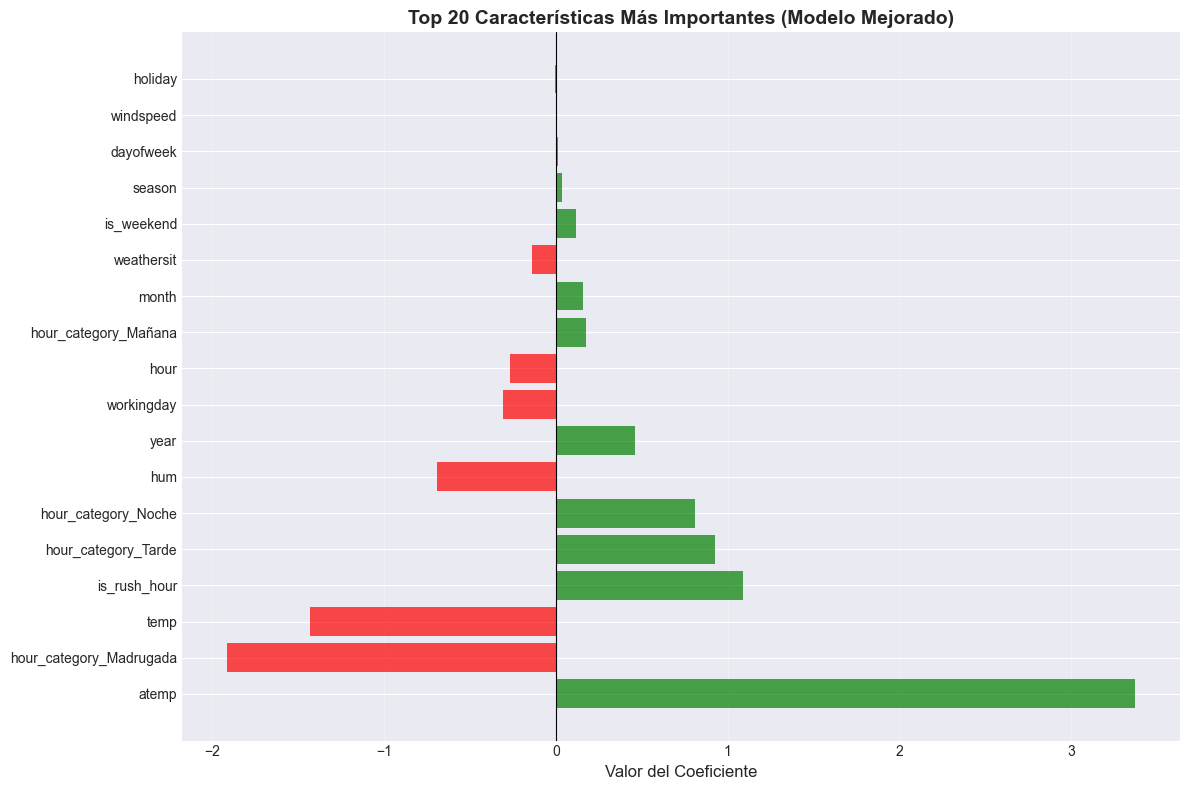

In [833]:
# --- Gráfico de importancia de coeficientes ---
print("\n Generando gráfico de importancia de coeficientes...")

coef_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': model_improved.coef_,
    'Abs_Coefficient': np.abs(model_improved.coef_)
}).sort_values('Abs_Coefficient', ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in coef_importance['Coefficient']]
plt.barh(range(len(coef_importance)), coef_importance['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(coef_importance)), coef_importance['Feature'])
plt.xlabel('Valor del Coeficiente', fontsize=12)
plt.title('Top 20 Características Más Importantes (Modelo Mejorado)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('04_coefficient_importance.png', dpi=300, bbox_inches='tight')
plt.show()



In [834]:
# --- Análisis de Multicolinealidad (VIF) ---


print("\n Factor de Inflación de Varianza (VIF):")
print("   • VIF < 5:  No hay multicolinealidad preocupante")
print("   • VIF 5-10: Multicolinealidad moderada")
print("   • VIF > 10: Multicolinealidad severa")

# Calcular VIF para las variables originales corregidas
vif_data = train[original_features].copy()

# Asegurarse de que no hay valores constantes
if vif_data.std().min() > 0:
    vif_results = pd.DataFrame()
    vif_results['Variable'] = original_features
    vif_results['VIF'] = [
        variance_inflation_factor(vif_data.values, i)
        for i in range(len(original_features))
    ]
    
    print(f"\n📊 Resultados VIF para variables originales (sin 'temp'):")
    print(vif_results.to_string(index=False))
    
    for _, row in vif_results.iterrows():
        var = row['Variable']
        vif = row['VIF']
        if vif < 5:
            status = "✅ Multicolinealidad baja"
        elif vif < 10:
            status = "⚠️  Multicolinealidad moderada"
        else:
            status = "❌ Multicolinealidad severa"
        print(f"   {var:12s}: VIF = {vif:.2f} → {status}")
    
   
else:
    print("   ⚠️  No se puede calcular VIF (variables sin variación)")



 Factor de Inflación de Varianza (VIF):
   • VIF < 5:  No hay multicolinealidad preocupante
   • VIF 5-10: Multicolinealidad moderada
   • VIF > 10: Multicolinealidad severa

📊 Resultados VIF para variables originales (sin 'temp'):
  Variable        VIF
    season   6.981545
   holiday   1.104263
workingday   3.123925
weathersit   7.237580
      temp 481.134276
     atemp 529.416948
       hum  11.659416
 windspeed   2.993557
   season      : VIF = 6.98 → ⚠️  Multicolinealidad moderada
   holiday     : VIF = 1.10 → ✅ Multicolinealidad baja
   workingday  : VIF = 3.12 → ✅ Multicolinealidad baja
   weathersit  : VIF = 7.24 → ⚠️  Multicolinealidad moderada
   temp        : VIF = 481.13 → ❌ Multicolinealidad severa
   atemp       : VIF = 529.42 → ❌ Multicolinealidad severa
   hum         : VIF = 11.66 → ❌ Multicolinealidad severa
   windspeed   : VIF = 2.99 → ✅ Multicolinealidad baja


--- 1. Modelo Base - Escala Logarítmica ---


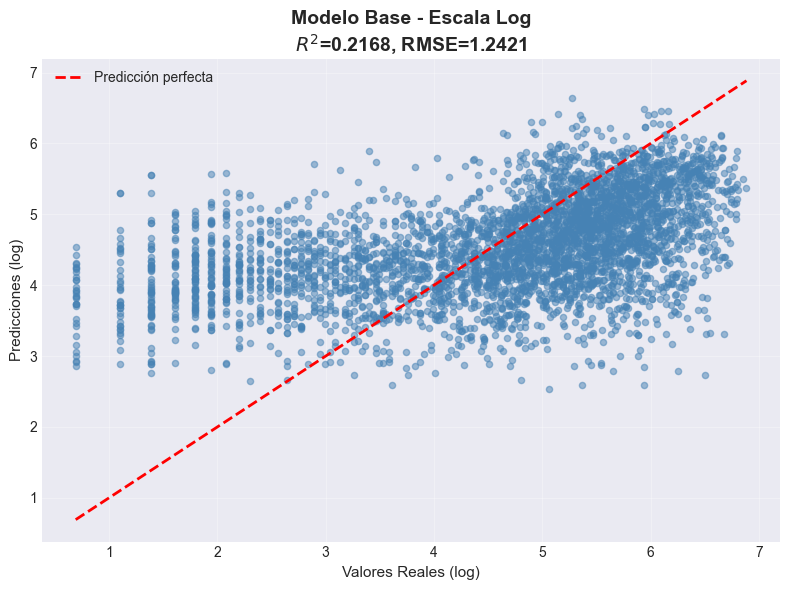

In [835]:
print("--- 1. Modelo Base - Escala Logarítmica ---")
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5, s=20, color='steelblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Valores Reales (log)', fontsize=11)
plt.ylabel('Predicciones (log)', fontsize=11)
plt.title(f'Modelo Base - Escala Log\n$R^2$={r2_log_val:.4f}, RMSE={rmse_log_val:.4f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

--- 2. Modelo Base - Escala Original (Count) ---


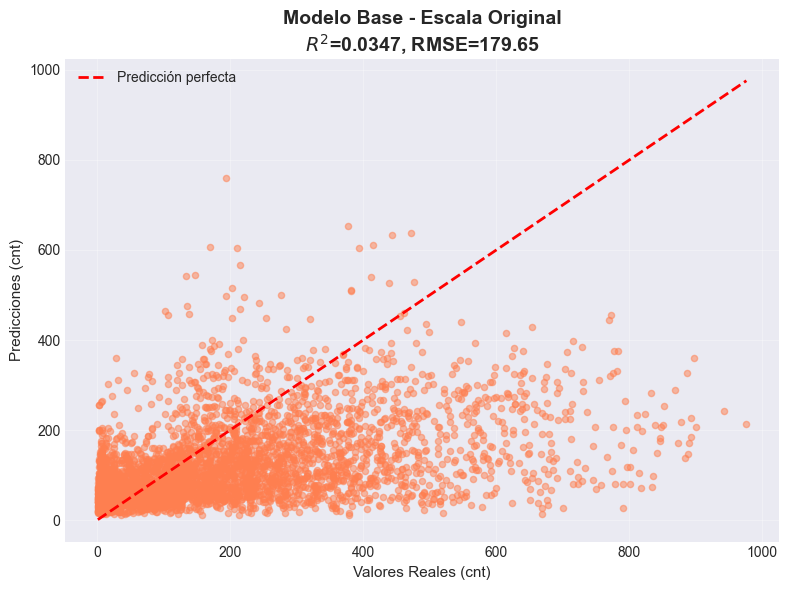

In [836]:
print("--- 2. Modelo Base - Escala Original (Count) ---")
plt.figure(figsize=(8, 6))
plt.scatter(y_val_original, y_pred_val_original, alpha=0.5, s=20, color='coral')
plt.plot([y_val_original.min(), y_val_original.max()],
         [y_val_original.min(), y_val_original.max()],
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Valores Reales (cnt)', fontsize=11)
plt.ylabel('Predicciones (cnt)', fontsize=11)
plt.title(f'Modelo Base - Escala Original\n$R^2$={r2_original_val:.4f}, RMSE={rmse_original_val:.2f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

--- 3. Modelo Mejorado - Escala Logarítmica ---


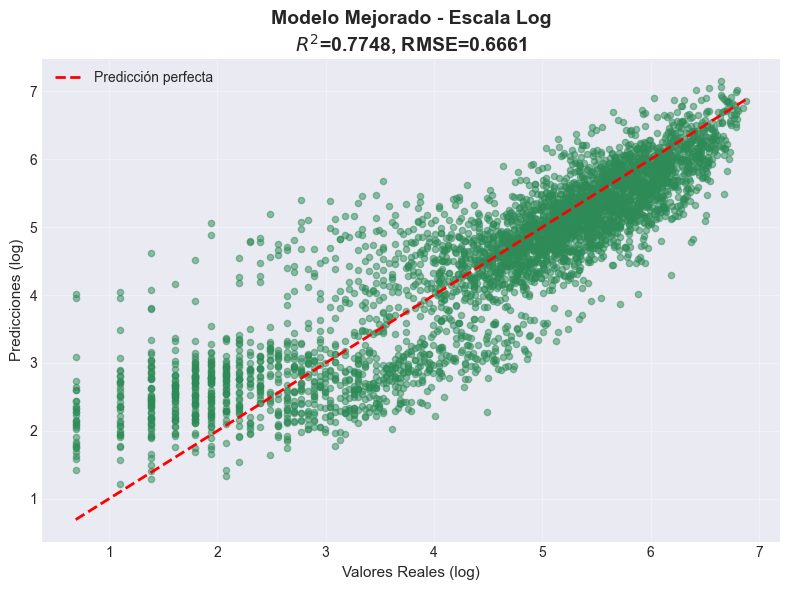

In [837]:
print("--- 3. Modelo Mejorado - Escala Logarítmica ---")
plt.figure(figsize=(8, 6))
plt.scatter(y_val_full, y_pred_val_improved, alpha=0.5, s=20, color='seagreen')
plt.plot([y_val_full.min(), y_val_full.max()],
         [y_val_full.min(), y_val_full.max()],
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Valores Reales (log)', fontsize=11)
plt.ylabel('Predicciones (log)', fontsize=11)
plt.title(f'Modelo Mejorado - Escala Log\n$R^2$={r2_log_val_improved:.4f}, RMSE={rmse_log_val_improved:.4f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

--- 4. Modelo Mejorado - Escala Original (Count) ---


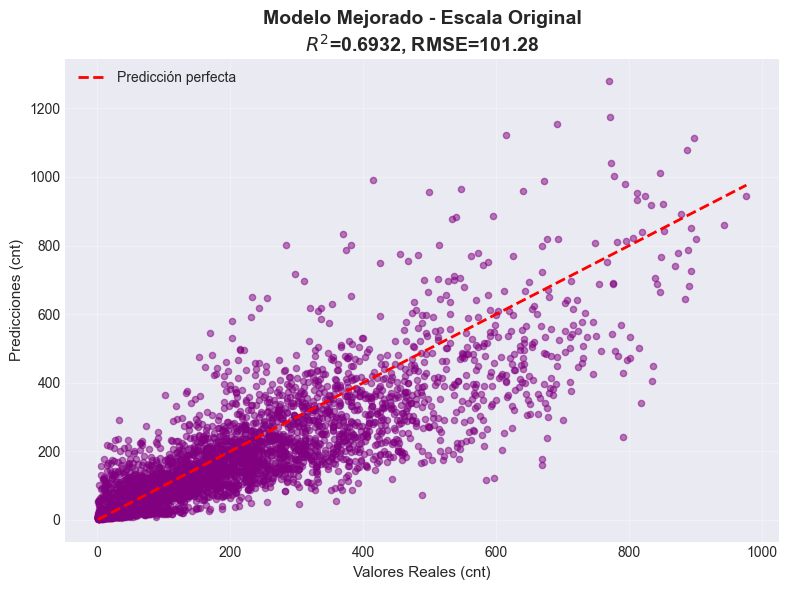

In [838]:
print("--- 4. Modelo Mejorado - Escala Original (Count) ---")
plt.figure(figsize=(8, 6))
plt.scatter(y_val_full_original, y_pred_val_improved_original, alpha=0.5, s=20, color='purple')
plt.plot([y_val_full_original.min(), y_val_full_original.max()],
         [y_val_full_original.min(), y_val_full_original.max()],
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Valores Reales (cnt)', fontsize=11)
plt.ylabel('Predicciones (cnt)', fontsize=11)
plt.title(f'Modelo Mejorado - Escala Original\n$R^2$={r2_original_val_improved:.4f}, RMSE={rmse_original_val_improved:.2f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [839]:
# --- Resumen de residuos ---

residuals_base = y_val - y_pred_val
residuals_improved = y_val_full - y_pred_val_improved


print("\n🎯 MODELO BASE:")
print(f"   Media de residuos:    {residuals_base.mean():.4f}")
print(f"   Std de residuos:      {residuals_base.std():.4f}")
print(f"   Residuo máximo:       {residuals_base.max():.4f}")
print(f"   Residuo mínimo:       {residuals_base.min():.4f}")

print("\n🎯 MODELO MEJORADO:")
print(f"   Media de residuos:    {residuals_improved.mean():.4f}")
print(f"   Std de residuos:      {residuals_improved.std():.4f}")
print(f"   Residuo máximo:       {residuals_improved.max():.4f}")
print(f"   Residuo mínimo:       {residuals_improved.min():.4f}")



🎯 MODELO BASE:
   Media de residuos:    0.0698
   Std de residuos:      1.2403
   Residuo máximo:       3.7743
   Residuo mínimo:       -4.2052

🎯 MODELO MEJORADO:
   Media de residuos:    0.0526
   Std de residuos:      0.6641
   Residuo máximo:       2.2110
   Residuo mínimo:       -3.3267


# ============================================================================
# PARTE 3: REGULARIZACIÓN - RIDGE Y LASSO
# ============================================================================



# ============================================================================
# PREPARACIÓN DE DATOS PARA VALIDACIÓN CRUZADA
# ============================================================================


In [840]:
# Combinar train y validation para TimeSeriesSplit
train_val_combined = pd.concat([train_encoded, validation_encoded], axis=0).reset_index(drop=True)

X_train_val = train_val_combined[all_features]
y_train_val = train_val_combined['log_count']

print(f"\n📊 Datos combinados para validación cruzada temporal:")
print(f"   Total de registros: {len(train_val_combined):,}")
print(f"   Características:    {len(all_features)}")
print(f"   Rango de fechas:    {train_val_combined['datetime'].min()} a {train_val_combined['datetime'].max()}")

# Configurar TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\n🔄 TimeSeriesSplit configurado:")
print(f"   Número de splits: {n_splits}")
print(f"\n   Distribución de datos por fold:")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
    print(f"   Fold {fold}: Train={len(train_idx):,} | Validation={len(val_idx):,}")



📊 Datos combinados para validación cruzada temporal:
   Total de registros: 12,034
   Características:    18
   Rango de fechas:    2011-01-01 00:00:00 a 2012-12-21 23:00:00

🔄 TimeSeriesSplit configurado:
   Número de splits: 5

   Distribución de datos por fold:
   Fold 1: Train=2,009 | Validation=2,005
   Fold 2: Train=4,014 | Validation=2,005
   Fold 3: Train=6,019 | Validation=2,005
   Fold 4: Train=8,024 | Validation=2,005
   Fold 5: Train=10,029 | Validation=2,005



# ============================================================================
# 3a) IMPLEMENTACIÓN DE RIDGE 
# ============================================================================


In [841]:

# Rango de valores alpha
alphas = np.logspace(-3, 3, 50)  # 50 valores entre 10^-3 y 10^3

# --- Búsqueda de alpha óptimo ---
print("\n🔧 Ejecutando validación cruzada para Ridge...")

ridge_scores = []
ridge_r2_scores = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    fold_scores = []
    fold_r2 = []
    
    for train_idx, val_idx in tscv.split(X_train_val):
        X_tr, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        fold_scores.append(rmse)
        fold_r2.append(r2)
    
    ridge_scores.append(np.mean(fold_scores))
    ridge_r2_scores.append(np.mean(fold_r2))



🔧 Ejecutando validación cruzada para Ridge...


In [842]:
# Alpha óptimo
optimal_idx_ridge = np.argmin(ridge_scores)
optimal_alpha_ridge = alphas[optimal_idx_ridge]
optimal_rmse_ridge = ridge_scores[optimal_idx_ridge]
optimal_r2_ridge = ridge_r2_scores[optimal_idx_ridge]

print(f"\n🎯 RESULTADOS RIDGE:")
print(f"   Alpha óptimo:        {optimal_alpha_ridge:.4f}")
print(f"   RMSE promedio (CV):  {optimal_rmse_ridge:.4f}")
print(f"   R² promedio (CV):    {optimal_r2_ridge:.4f}")

ridge_model = Ridge(alpha=optimal_alpha_ridge)
ridge_model.fit(X_train_val, y_train_val)

# Evaluar en conjunto de validación separado
X_val_final = validation_encoded[all_features]
y_val_final = validation_encoded['log_count']
y_pred_ridge = ridge_model.predict(X_val_final)

rmse_ridge_val = np.sqrt(mean_squared_error(y_val_final, y_pred_ridge))
mae_ridge_val = mean_absolute_error(y_val_final, y_pred_ridge)
r2_ridge_val = r2_score(y_val_final, y_pred_ridge)

# Escala original
y_pred_ridge_original = np.expm1(y_pred_ridge)
y_val_original = validation_encoded['cnt']
rmse_ridge_original = np.sqrt(mean_squared_error(y_val_original, y_pred_ridge_original))
mae_ridge_original = mean_absolute_error(y_val_original, y_pred_ridge_original)
r2_ridge_original = r2_score(y_val_original, y_pred_ridge_original)




🎯 RESULTADOS RIDGE:
   Alpha óptimo:        0.1600
   RMSE promedio (CV):  0.7481
   R² promedio (CV):    0.6923



 Generando gráfico de coeficientes vs alpha...


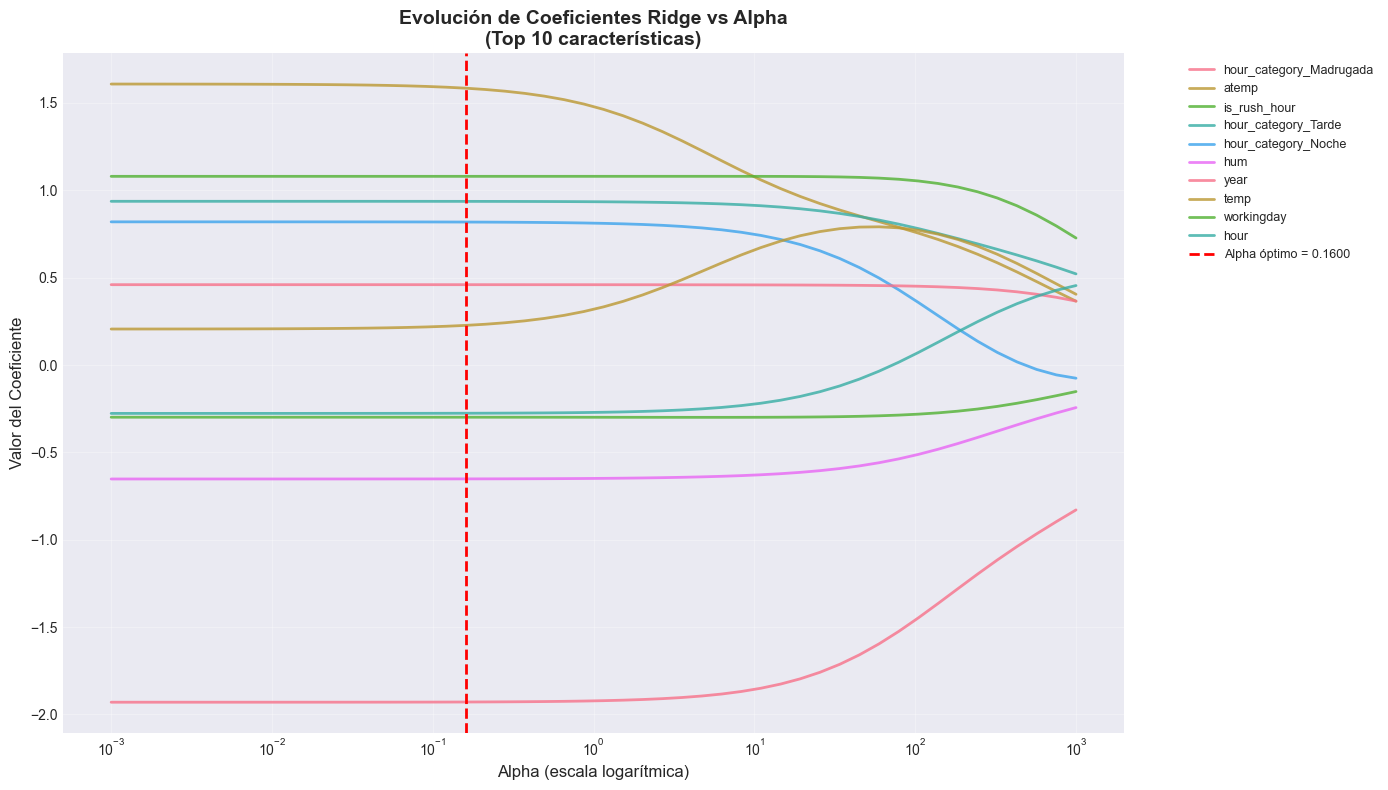

In [843]:
# --- Gráfico: Evolución de coeficientes vs Alpha ---
print("\n Generando gráfico de coeficientes vs alpha...")

# Calcular coeficientes para diferentes alphas
coef_paths = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_val, y_train_val)
    coef_paths.append(model.coef_)

coef_paths = np.array(coef_paths)

# Seleccionar top 10 características más importantes (por magnitud promedio)
avg_coef_magnitude = np.abs(coef_paths).mean(axis=0)
top_features_idx = np.argsort(avg_coef_magnitude)[-10:][::-1]

plt.figure(figsize=(14, 8))
for idx in top_features_idx:
    plt.plot(alphas, coef_paths[:, idx], linewidth=2, label=all_features[idx], alpha=0.8)

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)', fontsize=12)
plt.ylabel('Valor del Coeficiente', fontsize=12)
plt.title('Evolución de Coeficientes Ridge vs Alpha\n(Top 10 características)', 
          fontsize=14, fontweight='bold')
plt.axvline(optimal_alpha_ridge, color='red', linestyle='--', linewidth=2, 
            label=f'Alpha óptimo = {optimal_alpha_ridge:.4f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


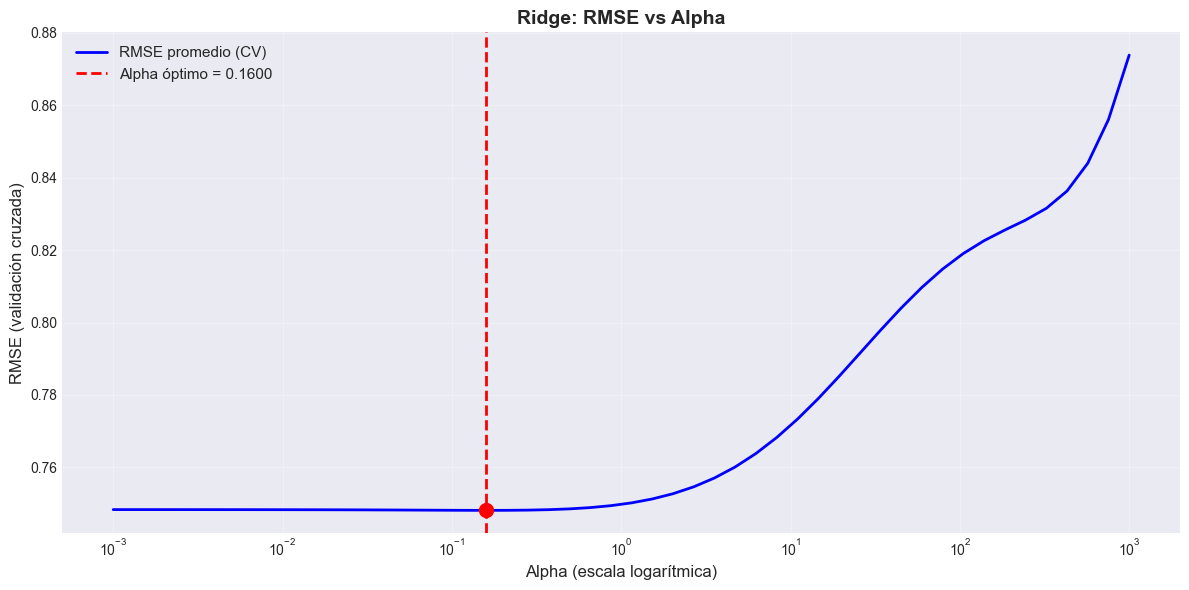

In [844]:

# --- Gráfico: RMSE vs Alpha ---
plt.figure(figsize=(12, 6))
plt.semilogx(alphas, ridge_scores, 'b-', linewidth=2, label='RMSE promedio (CV)')
plt.axvline(optimal_alpha_ridge, color='red', linestyle='--', linewidth=2, 
            label=f'Alpha óptimo = {optimal_alpha_ridge:.4f}')
plt.scatter([optimal_alpha_ridge], [optimal_rmse_ridge], color='red', s=100, zorder=5)
plt.xlabel('Alpha (escala logarítmica)', fontsize=12)
plt.ylabel('RMSE (validación cruzada)', fontsize=12)
plt.title('Ridge: RMSE vs Alpha', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# ============================================================================
# 3b) IMPLEMENTACIÓN DE LASSO 
# ============================================================================


In [845]:
# --- Búsqueda de alpha óptimo ---
print(f"\n🔧 Ejecutando validación cruzada para LASSO...")

lasso_scores = []
lasso_r2_scores = []
lasso_warnings = 0

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000, tol=1e-4)
    fold_scores = []
    fold_r2 = []
    
    for train_idx, val_idx in tscv.split(X_train_val):
        X_tr, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        fold_scores.append(rmse)
        fold_r2.append(r2)
    
    lasso_scores.append(np.mean(fold_scores))
    lasso_r2_scores.append(np.mean(fold_r2))


🔧 Ejecutando validación cruzada para LASSO...


In [846]:
# Alpha óptimo
optimal_idx_lasso = np.argmin(lasso_scores)
optimal_alpha_lasso = alphas[optimal_idx_lasso]
optimal_rmse_lasso = lasso_scores[optimal_idx_lasso]
optimal_r2_lasso = lasso_r2_scores[optimal_idx_lasso]

In [847]:
# --- Entrenar modelo final LASSO ---
print("\n🔧 Entrenando modelo LASSO final con alpha óptimo...")
lasso_model = Lasso(alpha=optimal_alpha_lasso, max_iter=10000, tol=1e-4)
lasso_model.fit(X_train_val, y_train_val)

# Evaluar en conjunto de validación
y_pred_lasso = lasso_model.predict(X_val_final)

rmse_lasso_val = np.sqrt(mean_squared_error(y_val_final, y_pred_lasso))
mae_lasso_val = mean_absolute_error(y_val_final, y_pred_lasso)
r2_lasso_val = r2_score(y_val_final, y_pred_lasso)

# Escala original
y_pred_lasso_original = np.expm1(y_pred_lasso)
rmse_lasso_original = np.sqrt(mean_squared_error(y_val_original, y_pred_lasso_original))
mae_lasso_original = mean_absolute_error(y_val_original, y_pred_lasso_original)
r2_lasso_original = r2_score(y_val_original, y_pred_lasso_original)

print("\n📊 MÉTRICAS LASSO (Validation set):")
print(f"   Escala logarítmica:")
print(f"      RMSE: {rmse_lasso_val:.4f}")
print(f"      MAE:  {mae_lasso_val:.4f}")
print(f"      R²:   {r2_lasso_val:.4f}")
print(f"\n   Escala original:")
print(f"      RMSE: {rmse_lasso_original:.2f} bicicletas")
print(f"      MAE:  {mae_lasso_original:.2f} bicicletas")
print(f"      R²:   {r2_lasso_original:.4f}")


🔧 Entrenando modelo LASSO final con alpha óptimo...

📊 MÉTRICAS LASSO (Validation set):
   Escala logarítmica:
      RMSE: 0.6563
      MAE:  0.4892
      R²:   0.7813

   Escala original:
      RMSE: 99.12 bicicletas
      MAE:  64.38 bicicletas
      R²:   0.7061


In [848]:
# --- Análisis de selección de características ---

print("🔍 ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS")

# Identificar variables eliminadas (coeficientes = 0)
zero_coefs = np.abs(lasso_model.coef_) < 1e-10
n_zero = zero_coefs.sum()
n_selected = len(all_features) - n_zero

print(f"\n📊 LASSO - Selección de características:")
print(f"   Total de características:     {len(all_features)}")
print(f"   Características seleccionadas: {n_selected}")
print(f"   Características eliminadas:    {n_zero}")
print(f"   Porcentaje seleccionado:       {n_selected/len(all_features)*100:.1f}%")

# Variables eliminadas
eliminated_features = [feat for feat, is_zero in zip(all_features, zero_coefs) if is_zero]
if len(eliminated_features) > 0:
    print(f"\n❌ Variables eliminadas por LASSO ({len(eliminated_features)}):")
    for i, feat in enumerate(eliminated_features[:20], 1):  # Mostrar máximo 20
        print(f"   {i:2d}. {feat}")
    if len(eliminated_features) > 20:
        print(f"   ... y {len(eliminated_features) - 20} más")
else:
    print("\n   ✅ Ninguna variable fue eliminada")

🔍 ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS

📊 LASSO - Selección de características:
   Total de características:     18
   Características seleccionadas: 18
   Características eliminadas:    0
   Porcentaje seleccionado:       100.0%

   ✅ Ninguna variable fue eliminada


In [849]:
# Variables seleccionadas más importantes
selected_coefs = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': lasso_model.coef_,
    'Abs_Coefficient': np.abs(lasso_model.coef_)
}).query('Abs_Coefficient > 1e-10').sort_values('Abs_Coefficient', ascending=False)

print(f"\n✅ Top 15 características seleccionadas (por importancia):")
print(selected_coefs.head(15)[['Feature', 'Coefficient']].to_string(index=False))

# --- Comparación Ridge vs LASSO ---
print(f"\n{'='*60}")
print("⚖️  COMPARACIÓN: RIDGE vs LASSO")
print("="*60)

ridge_nonzero = np.sum(np.abs(ridge_model.coef_) > 1e-10)
lasso_nonzero = np.sum(np.abs(lasso_model.coef_) > 1e-10)

comparison_reg = pd.DataFrame({
    'Característica': ['Características activas', 'Características eliminadas', 
                       'RMSE (log)', 'R²', 'RMSE (original)'],
    'Ridge': [ridge_nonzero, len(all_features) - ridge_nonzero, 
              rmse_ridge_val, r2_ridge_val, rmse_ridge_original],
    'LASSO': [lasso_nonzero, len(all_features) - lasso_nonzero,
              rmse_lasso_val, r2_lasso_val, rmse_lasso_original]
})

print("\n" + comparison_reg.to_string(index=False))
print(f"\n💡 INTERPRETACIÓN:")
print(f"   • Ridge mantiene TODAS las características con coeficientes pequeños")
print(f"   • LASSO elimina {n_zero} características (selección automática)")
if r2_lasso_val > r2_ridge_val:
    print(f"   • LASSO tiene mejor desempeño en este caso (R² más alto)")
else:
    print(f"   • Ridge tiene mejor desempeño en este caso (R² más alto)")



✅ Top 15 características seleccionadas (por importancia):
                Feature  Coefficient
hour_category_Madrugada    -2.464745
                  atemp     1.511396
           is_rush_hour     1.076479
                    hum    -0.604321
                   year     0.458024
   hour_category_Mañana    -0.422425
             workingday    -0.290493
    hour_category_Tarde     0.275600
                   temp     0.267309
                   hour    -0.204555
             weathersit    -0.149934
                  month     0.147184
             is_weekend     0.136612
    hour_category_Noche     0.092621
              windspeed    -0.061280

⚖️  COMPARACIÓN: RIDGE vs LASSO

            Característica     Ridge     LASSO
   Características activas 18.000000 18.000000
Características eliminadas  0.000000  0.000000
                RMSE (log)  0.655542  0.656290
                        R²  0.781844  0.781346
           RMSE (original) 99.706856 99.121642

💡 INTERPRETACIÓN:
   • Ridge man


📊 Generando gráfico de coeficientes Ridge...


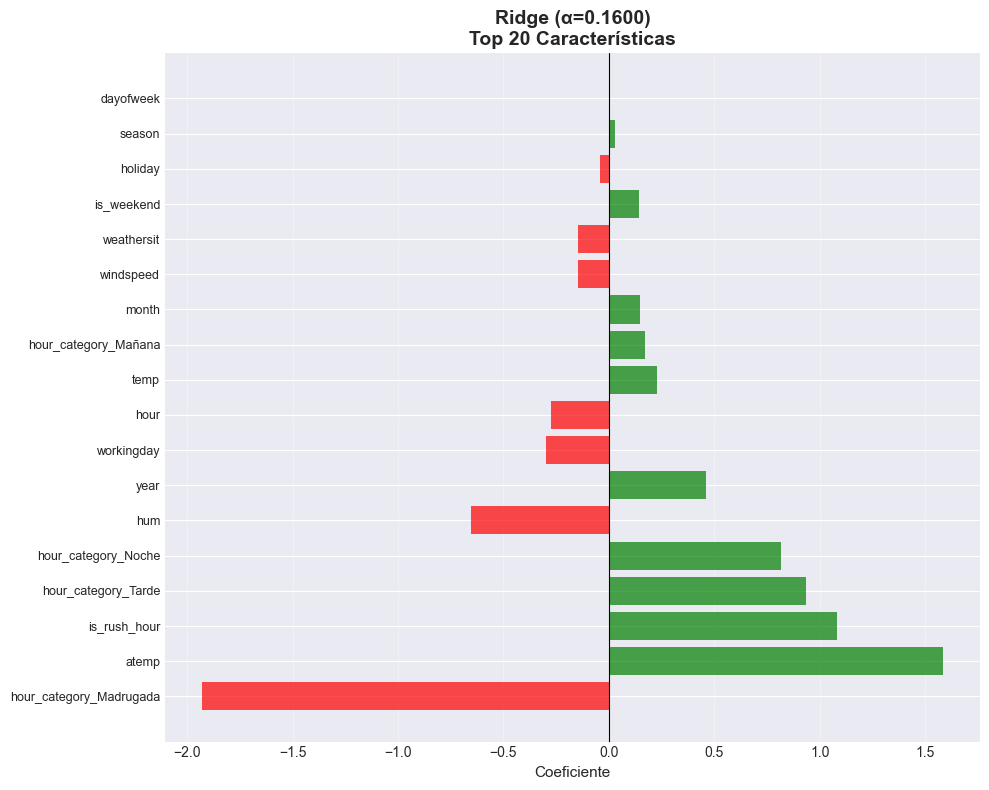

In [850]:
# --- Gráfico de Coeficientes Ridge ---
print("\n📊 Generando gráfico de coeficientes Ridge...")

# 1. Preparación de datos 
ridge_coefs = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': ridge_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

colors_ridge = ['green' if x > 0 else 'red' for x in ridge_coefs['Coefficient']]


# 2. Creación del gráfico
plt.figure(figsize=(10, 8)) # Ajustamos el tamaño para una sola figura
ax = plt.gca() # Obtiene el eje actual

ax.barh(range(len(ridge_coefs)), ridge_coefs['Coefficient'], color=colors_ridge, alpha=0.7)
ax.set_yticks(range(len(ridge_coefs)))
ax.set_yticklabels(ridge_coefs['Feature'], fontsize=9)
ax.set_xlabel('Coeficiente', fontsize=11)
ax.set_title(f'Ridge (α={optimal_alpha_ridge:.4f})\nTop 20 Características', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



📊 Generando gráfico de coeficientes LASSO...


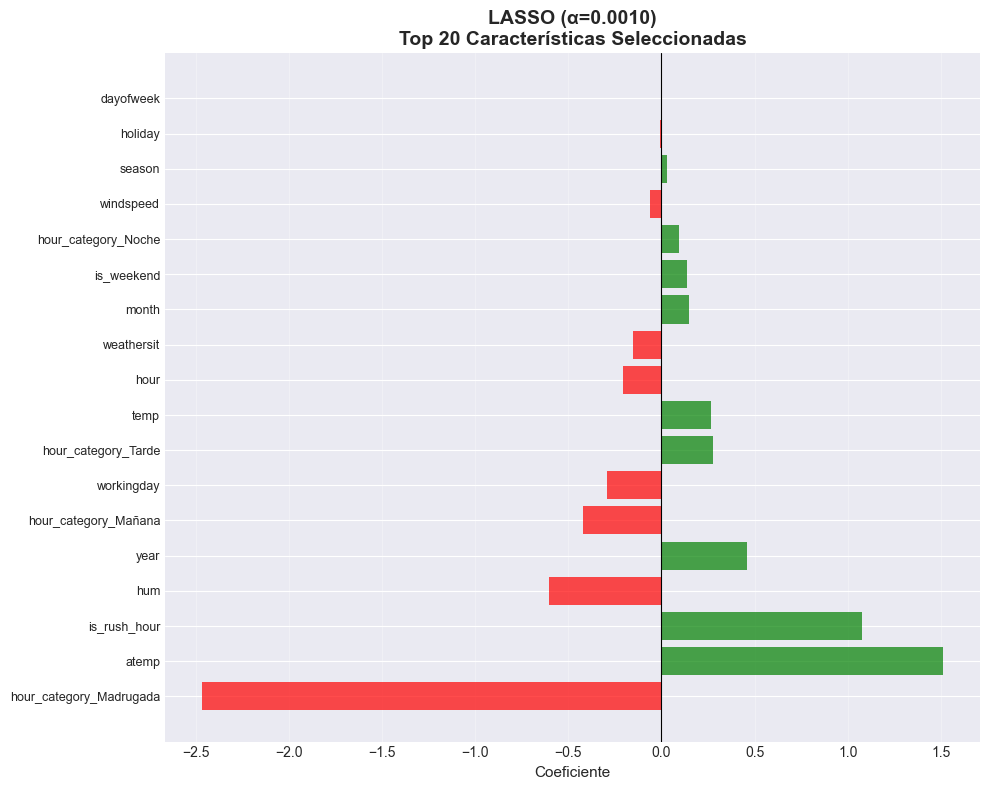

In [851]:

# --- Gráfico de Coeficientes LASSO ---
print("\n📊 Generando gráfico de coeficientes LASSO...")

# 1. Preparación de datos (Igual que en tu código original)
# Nota: Asumimos que 'selected_coefs' ya contiene los coeficientes no cero y está ordenado.
lasso_coefs = selected_coefs.head(20)

colors_lasso = ['green' if x > 0 else 'red' for x in lasso_coefs['Coefficient']]

# 2. Creación del gráfico
plt.figure(figsize=(10, 8)) # Ajustamos el tamaño para una sola figura
ax = plt.gca() # Obtiene el eje actual

ax.barh(range(len(lasso_coefs)), lasso_coefs['Coefficient'], color=colors_lasso, alpha=0.7)
ax.set_yticks(range(len(lasso_coefs)))
ax.set_yticklabels(lasso_coefs['Feature'], fontsize=9)
ax.set_xlabel('Coeficiente', fontsize=11)
ax.set_title(f'LASSO (α={optimal_alpha_lasso:.4f})\nTop 20 Características Seleccionadas', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# TABLA COMPARATIVA COMPLETA
# ============================================================================


In [852]:

# Crear tabla comparativa completa
# Nota: Usar las métricas de validation guardadas de la Parte 2
comparison_all = pd.DataFrame({
    'Modelo': ['Lineal Base', 'Lineal Mejorado', 'Ridge', 'LASSO'],
    'N° Features': [len(original_features), len(all_features), 
                    ridge_nonzero, lasso_nonzero],
    'RMSE (log)': [rmse_log_val, rmse_log_val_improved, rmse_ridge_val, rmse_lasso_val],
    'MAE (log)': [mae_log_val, mae_log_val_improved, mae_ridge_val, mae_lasso_val],
    'R² (log)': [r2_log_val, r2_log_val_improved, r2_ridge_val, r2_lasso_val],
    'RMSE (original)': [rmse_original_val, rmse_original_val_improved, 
                        rmse_ridge_original, rmse_lasso_original],
    'MAE (original)': [mae_original_val, mae_original_val_improved,
                       mae_ridge_original, mae_lasso_original]
})

print("\n" + comparison_all.to_string(index=False))

# Identificar mejor modelo
best_model_idx = comparison_all['R² (log)'].idxmax()
best_model_name = comparison_all.loc[best_model_idx, 'Modelo']

print(f"\n🏆 MEJOR MODELO (basado en R²): {best_model_name}")
print(f"   R²:   {comparison_all.loc[best_model_idx, 'R² (log)']:.4f}")
print(f"   RMSE: {comparison_all.loc[best_model_idx, 'RMSE (original)']:.2f} bicicletas")



         Modelo  N° Features  RMSE (log)  MAE (log)  R² (log)  RMSE (original)  MAE (original)
    Lineal Base            8    1.242066   0.976438  0.216832       179.652754      122.095264
Lineal Mejorado           18    0.666087   0.498056  0.774769       101.275697       65.761094
          Ridge           18    0.655542   0.488802  0.781844        99.706856       64.563115
          LASSO           18    0.656290   0.489198  0.781346        99.121642       64.381352

🏆 MEJOR MODELO (basado en R²): Ridge
   R²:   0.7818
   RMSE: 99.71 bicicletas



# ============================================================================
# PARTE 4: ELASTIC NET Y ANÁLISIS AVANZADO 
# ============================================================================


In [ ]:
print("4a) ELASTIC NET")
# Configuración de hiperparámetros
alphas = np.logspace(-3, 3, 30)  # 30 valores de alpha
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]


# TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
# --- Búsqueda de hiperparámetros óptimos ---
print("\n🔧 Ejecutando grid search con validación cruzada...")
print("   (Esto puede tomar unos minutos...)")

best_score = float('inf')
best_params = {}
results = []

for l1_ratio in l1_ratios:
    for alpha in alphas:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, tol=1e-4)
        fold_scores = []
        
        for train_idx, val_idx in tscv.split(X_train_val):
            X_tr, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_scores.append(rmse)
        
        mean_rmse = np.mean(fold_scores)
        results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'rmse_cv': mean_rmse
        })
        
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

print("   ✅ Grid search completado")

results_df = pd.DataFrame(results)

print(f"\n🎯 HIPERPARÁMETROS ÓPTIMOS:")
print(f"   Alpha óptimo:        {best_params['alpha']:.4f}")
print(f"   L1_ratio óptimo:     {best_params['l1_ratio']:.2f}")
print(f"   RMSE promedio (CV):  {best_score:.4f}")





4a) ELASTIC NET

🔧 Ejecutando grid search con validación cruzada...
   (Esto puede tomar unos minutos...)
   ✅ Grid search completado

🎯 HIPERPARÁMETROS ÓPTIMOS:
   Alpha óptimo:        0.0010
   L1_ratio óptimo:     0.10
   RMSE promedio (CV):  0.7573


In [854]:
# Interpretación del l1_ratio
l1_ratio_optimal = best_params['l1_ratio']
if l1_ratio_optimal < 0.3:
    interpretation = "más cercano a Ridge (penalización L2 dominante)"
elif l1_ratio_optimal > 0.7:
    interpretation = "más cercano a LASSO (penalización L1 dominante)"
else:
    interpretation = "balance equilibrado entre L1 y L2"

print(f"\n💡 Interpretación:")
print(f"   El modelo óptimo es {interpretation}")
print(f"   Peso L1 (LASSO): {l1_ratio_optimal:.1%}")
print(f"   Peso L2 (Ridge):  {(1-l1_ratio_optimal):.1%}")

# --- Entrenar modelo final Elastic Net ---
print("\n🔧 Entrenando modelo Elastic Net final...")
elasticnet_model = ElasticNet(
    alpha=best_params['alpha'], 
    l1_ratio=best_params['l1_ratio'],
    max_iter=10000,
    tol=1e-4
)
elasticnet_model.fit(X_train_val, y_train_val)



💡 Interpretación:
   El modelo óptimo es más cercano a Ridge (penalización L2 dominante)
   Peso L1 (LASSO): 10.0%
   Peso L2 (Ridge):  90.0%

🔧 Entrenando modelo Elastic Net final...


,alpha,np.float64(0.001)
,l1_ratio,0.1
,fit_intercept,True
,precompute,False
,max_iter,10000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [855]:
# Evaluar en conjunto de validación
X_val_final = validation_encoded[all_features]
y_val_final = validation_encoded['log_count']
y_pred_elasticnet = elasticnet_model.predict(X_val_final)

rmse_elasticnet_val = np.sqrt(mean_squared_error(y_val_final, y_pred_elasticnet))
mae_elasticnet_val = mean_absolute_error(y_val_final, y_pred_elasticnet)
r2_elasticnet_val = r2_score(y_val_final, y_pred_elasticnet)

# Escala original
y_pred_elasticnet_original = np.expm1(y_pred_elasticnet)
y_val_original = validation_encoded['cnt']
rmse_elasticnet_original = np.sqrt(mean_squared_error(y_val_original, y_pred_elasticnet_original))
mae_elasticnet_original = mean_absolute_error(y_val_original, y_pred_elasticnet_original)
r2_elasticnet_original = r2_score(y_val_original, y_pred_elasticnet_original)

print("\n📊 MÉTRICAS ELASTIC NET (Validation set):")
print(f"   Escala logarítmica:")
print(f"      RMSE: {rmse_elasticnet_val:.4f}")
print(f"      MAE:  {mae_elasticnet_val:.4f}")
print(f"      R²:   {r2_elasticnet_val:.4f}")
print(f"\n   Escala original:")
print(f"      RMSE: {rmse_elasticnet_original:.2f} bicicletas")
print(f"      MAE:  {mae_elasticnet_original:.2f} bicicletas")
print(f"      R²:   {r2_elasticnet_original:.4f}")


📊 MÉTRICAS ELASTIC NET (Validation set):
   Escala logarítmica:
      RMSE: 0.6552
      MAE:  0.4885
      R²:   0.7821

   Escala original:
      RMSE: 99.24 bicicletas
      MAE:  64.23 bicicletas
      R²:   0.7054



🔍 Selección de características:
   Características seleccionadas: 18/18
   Características eliminadas:    0

📊 Generando heatmap de búsqueda de hiperparámetros...


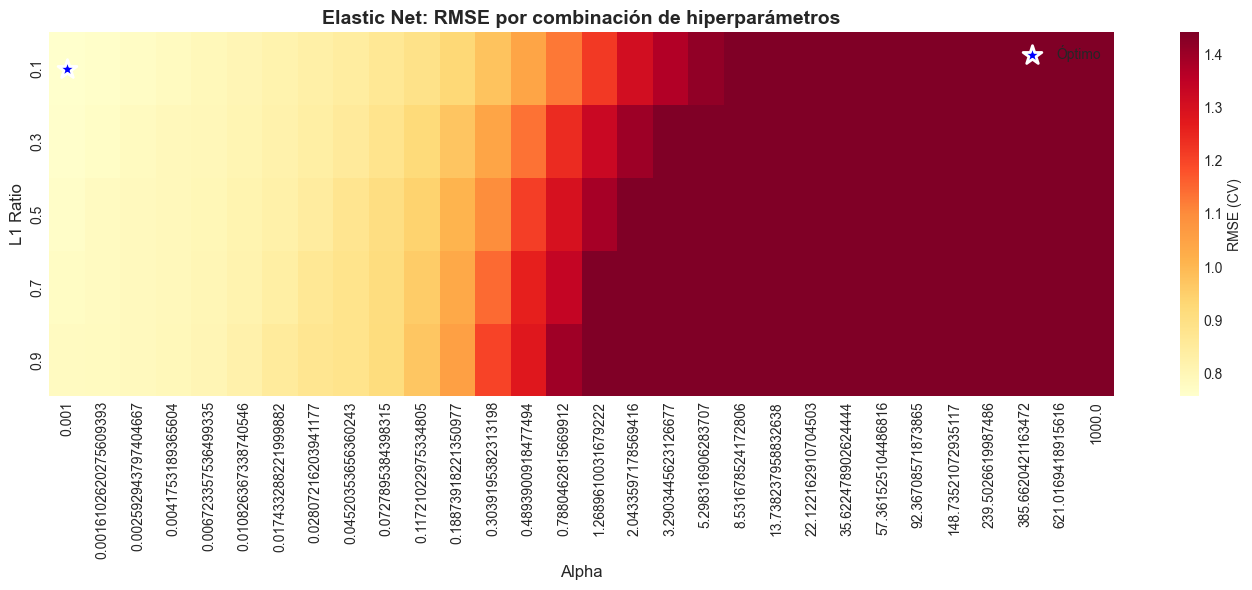

In [ ]:
# Análisis de características seleccionadas
zero_coefs_en = np.abs(elasticnet_model.coef_) < 1e-10
n_zero_en = zero_coefs_en.sum()
n_selected_en = len(all_features) - n_zero_en

print(f"\n🔍 Selección de características:")
print(f"   Características seleccionadas: {n_selected_en}/{len(all_features)}")
print(f"   Características eliminadas:    {n_zero_en}")

# --- Mapa de calor: RMSE vs hiperparámetros ---
print("\n📊 Generando heatmap de búsqueda de hiperparámetros...")

pivot_table = results_df.pivot(index='l1_ratio', columns='alpha', values='rmse_cv')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, fmt='.4f', cbar_kws={'label': 'RMSE (CV)'})
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('L1 Ratio', fontsize=12)
plt.title('Elastic Net: RMSE por combinación de hiperparámetros', fontsize=14, fontweight='bold')

# Marcar el punto óptimo
alpha_idx = list(pivot_table.columns).index(best_params['alpha'])
l1_idx = list(pivot_table.index).index(best_params['l1_ratio'])
plt.scatter(alpha_idx + 0.5, l1_idx + 0.5, s=200, c='blue', marker='*', 
            edgecolors='white', linewidths=2, label='Óptimo', zorder=5)
plt.legend()

plt.tight_layout()

plt.show()

In [857]:
# --- Tabla comparativa COMPLETA ---
print(f"\n{'='*80}")
print("📊 TABLA COMPARATIVA: TODOS LOS MODELOS")
print("="*80)

comparison_all = pd.DataFrame({
    'Modelo': ['Lineal Base', 'Lineal Mejorado', 'Ridge', 'LASSO', 'Elastic Net'],
    'N° Features': [len(original_features), len(all_features), 
                    len(all_features), lasso_nonzero, n_selected_en],
    'Hiperparámetros': ['-', '-', 
                        f'α={optimal_alpha_ridge:.4f}',
                        f'α={optimal_alpha_lasso:.4f}',
                        f'α={best_params["alpha"]:.4f}, l1={best_params["l1_ratio"]:.2f}'],
    'RMSE (log)': [rmse_log_val, rmse_log_val_improved, rmse_ridge_val, 
                   rmse_lasso_val, rmse_elasticnet_val],
    'R² (log)': [r2_log_val, r2_log_val_improved, r2_ridge_val, 
                 r2_lasso_val, r2_elasticnet_val],
    'RMSE (original)': [rmse_original_val, rmse_original_val_improved, 
                        rmse_ridge_original, rmse_lasso_original, rmse_elasticnet_original]
})

print("\n" + comparison_all.to_string(index=False))

# Identificar mejor modelo
best_model_idx = comparison_all['R² (log)'].idxmax()
best_model_name = comparison_all.loc[best_model_idx, 'Modelo']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   R²:   {comparison_all.loc[best_model_idx, 'R² (log)']:.4f}")
print(f"   RMSE: {comparison_all.loc[best_model_idx, 'RMSE (original)']:.2f} bicicletas")

# 


📊 TABLA COMPARATIVA: TODOS LOS MODELOS

         Modelo  N° Features   Hiperparámetros  RMSE (log)  R² (log)  RMSE (original)
    Lineal Base            8                 -    1.242066  0.216832       179.652754
Lineal Mejorado           18                 -    0.666087  0.774769       101.275697
          Ridge           18          α=0.1600    0.655542  0.781844        99.706856
          LASSO           18          α=0.0010    0.656290  0.781346        99.121642
    Elastic Net           18 α=0.0010, l1=0.10    0.655218  0.782059        99.243281

🏆 MEJOR MODELO: Elastic Net
   R²:   0.7821
   RMSE: 99.24 bicicletas


# ============================================================================
# 4b) ANÁLISIS DE RESIDUOS Y PATRONES TEMPORALES 
# ============================================================================


In [858]:
print("4b) ANÁLISIS DE RESIDUOS Y PATRONES TEMPORALES")

# Usar el mejor modelo para análisis de residuos
print(f"\n📊 Analizando residuos del modelo: Elastic Net")

residuals = y_val_final - y_pred_elasticnet
residuals_original = y_val_original - y_pred_elasticnet_original

print(f"\n📈 Estadísticas de residuos:")
print(f"   Media:     {residuals.mean():.6f} (idealmente ~0)")
print(f"   Std:       {residuals.std():.4f}")
print(f"   Min:       {residuals.min():.4f}")
print(f"   Max:       {residuals.max():.4f}")
print(f"   Q1:        {residuals.quantile(0.25):.4f}")
print(f"   Mediana:   {residuals.median():.4f}")
print(f"   Q3:        {residuals.quantile(0.75):.4f}")

4b) ANÁLISIS DE RESIDUOS Y PATRONES TEMPORALES

📊 Analizando residuos del modelo: Elastic Net

📈 Estadísticas de residuos:
   Media:     0.033308 (idealmente ~0)
   Std:       0.6545
   Min:       -3.3490
   Max:       1.8356
   Q1:        -0.2643
   Mediana:   0.0953
   Q3:        0.4340



📊 Generando gráfico de Residuos vs Predicciones (Log)...


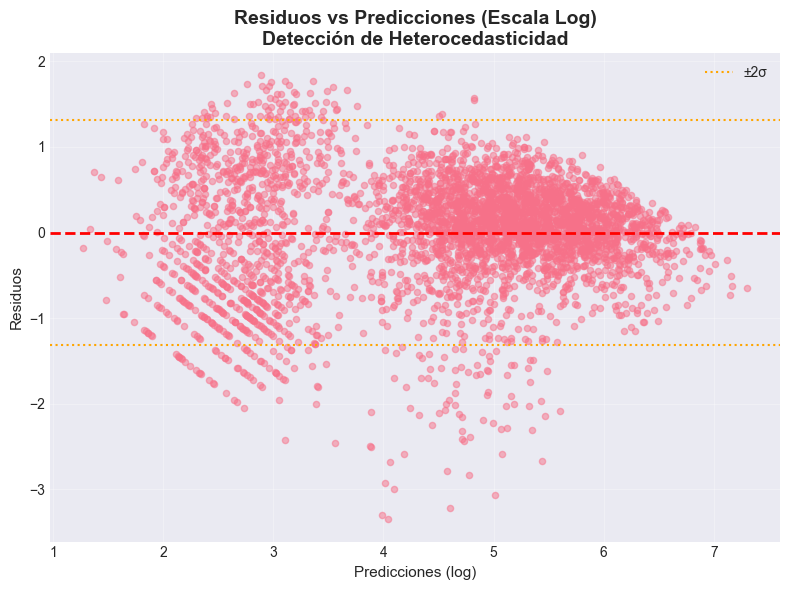

In [ ]:
# --- Residuos vs Predicciones (Escala Log) ---
print("\nGenerando gráfico de Residuos vs Predicciones (Log)...")

plt.figure(figsize=(8, 6))
ax = plt.gca()

ax.scatter(y_pred_elasticnet, residuals, alpha=0.5, s=20)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicciones (log)', fontsize=11)
ax.set_ylabel('Residuos', fontsize=11)
ax.set_title('Residuos vs Predicciones (Escala Log)\nDetección de Heterocedasticidad', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Agregar bandas de confianza (Asegúrate de que 'residuals' sea un array de NumPy o Pandas Series)
std_residuals = np.std(residuals)
ax.axhline(y=2*std_residuals, color='orange', linestyle=':', linewidth=1.5, label='±2σ')
ax.axhline(y=-2*std_residuals, color='orange', linestyle=':', linewidth=1.5)
ax.legend()

plt.tight_layout()
plt.show()


📊 Generando gráfico de Residuos vs Predicciones (Original)...


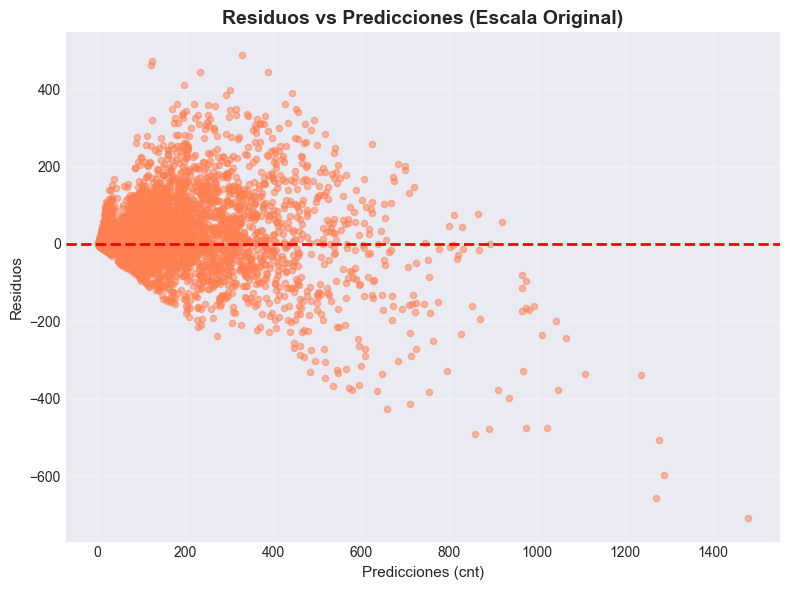

In [ ]:
# --- Residuos vs Predicciones (Escala Original) ---
print("\nGenerando gráfico de Residuos vs Predicciones (Original)...")

plt.figure(figsize=(8, 6))
ax = plt.gca()

ax.scatter(y_pred_elasticnet_original, residuals_original, alpha=0.5, s=20, color='coral')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicciones (cnt)', fontsize=11)
ax.set_ylabel('Residuos', fontsize=11)
ax.set_title('Residuos vs Predicciones (Escala Original)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📊 Generando Histograma de Residuos...


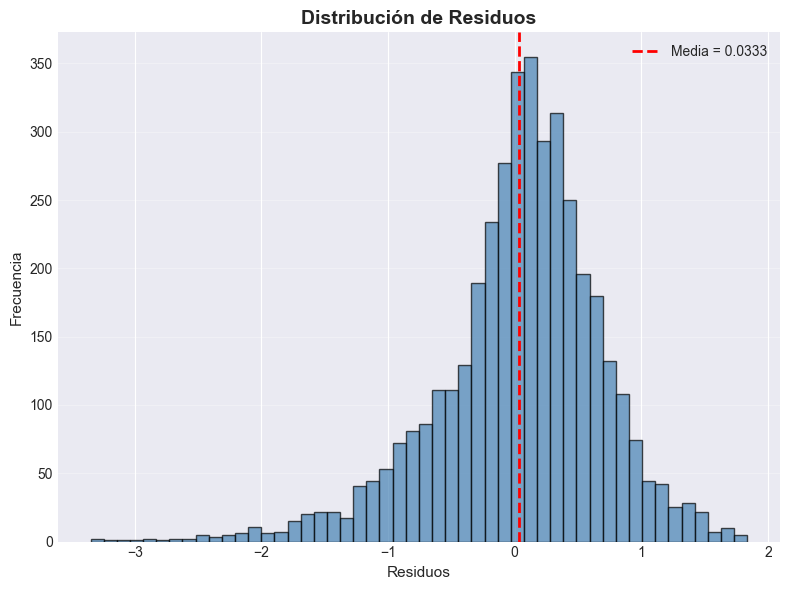

In [862]:
# --- Distribución de Residuos (Histograma) ---
print("\n📊 Generando Histograma de Residuos...")

plt.figure(figsize=(8, 6))
ax = plt.gca()

ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.mean(residuals), color='red', linestyle='--', linewidth=2, 
           label=f'Media = {np.mean(residuals):.4f}')
ax.set_xlabel('Residuos', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Residuos', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


📊 Generando Q-Q Plot de Normalidad...


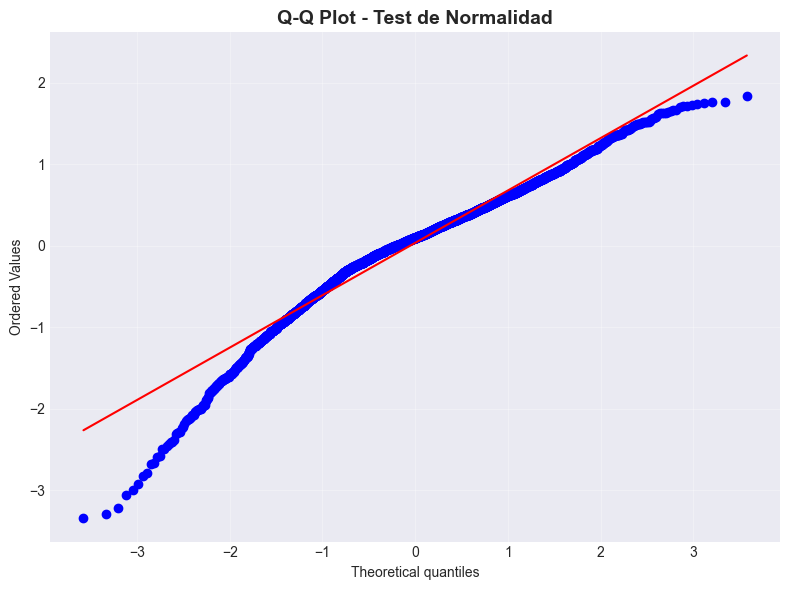

In [ ]:
# --- Q-Q Plot ---

print("\n Generando Q-Q Plot de Normalidad...")

plt.figure(figsize=(8, 6))
ax = plt.gca()

stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot - Test de Normalidad', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [864]:
# Interpretación de heterocedasticidad
print("\n💡 INTERPRETACIÓN DE HETEROCEDASTICIDAD:")
correlation_res_pred = np.corrcoef(np.abs(residuals), y_pred_elasticnet)[0, 1]
print(f"   Correlación |residuos| vs predicciones: {correlation_res_pred:.4f}")
if abs(correlation_res_pred) < 0.1:
    print("   ✅ Homocedasticidad: Varianza constante (bueno)")
elif abs(correlation_res_pred) < 0.3:
    print("   ⚠️  Heterocedasticidad leve detectada")
else:
    print("   ❌ Heterocedasticidad moderada/severa (revisar transformación)")


💡 INTERPRETACIÓN DE HETEROCEDASTICIDAD:
   Correlación |residuos| vs predicciones: -0.3859
   ❌ Heterocedasticidad moderada/severa (revisar transformación)


# ============================================================================
# PARTE 5: CONCLUSIONES Y RECOMENDACIONES
# ============================================================================


In [865]:
# Crear tabla resumen completa
summary_table = pd.DataFrame({
    'Modelo': [
        'Lineal Base',
        'Lineal Mejorado', 
        'Ridge',
        'LASSO',
        'Elastic Net'
    ],
    'N° Características': [
        len(original_features),
        len(all_features),
        len(all_features),
        lasso_nonzero,
        n_selected_en
    ],
    'Hiperparámetros': [
        'Ninguno',
        'Ninguno',
        f'α={optimal_alpha_ridge:.4f}',
        f'α={optimal_alpha_lasso:.4f}',
        f'α={best_params["alpha"]:.4f}, l1={best_params["l1_ratio"]:.2f}'
    ],
    'RMSE (log)': [
        rmse_log_val,
        rmse_log_val_improved,
        rmse_ridge_val,
        rmse_lasso_val,
        rmse_elasticnet_val
    ],
    'MAE (log)': [
        mae_log_val,
        mae_log_val_improved,
        mae_ridge_val,
        mae_lasso_val,
        mae_elasticnet_val
    ],
    'R² (log)': [
        r2_log_val,
        r2_log_val_improved,
        r2_ridge_val,
        r2_lasso_val,
        r2_elasticnet_val
    ],
    'RMSE (original)': [
        rmse_original_val,
        rmse_original_val_improved,
        rmse_ridge_original,
        rmse_lasso_original,
        rmse_elasticnet_original
    ],
    'MAE (original)': [
        mae_original_val,
        mae_original_val_improved,
        mae_ridge_original,
        mae_lasso_original,
        mae_elasticnet_original
    ]
})

In [866]:
# Añadir ranking
summary_table['Ranking'] = summary_table['R² (log)'].rank(ascending=False).astype(int)
summary_table = summary_table.sort_values('Ranking')

print("\n" + summary_table.to_string(index=False))

# Guardar tabla
summary_table.to_csv('summary_all_models.csv', index=False)
print("\n💾 Tabla guardada en: summary_all_models.csv")



         Modelo  N° Características   Hiperparámetros  RMSE (log)  MAE (log)  R² (log)  RMSE (original)  MAE (original)  Ranking
    Elastic Net                  18 α=0.0010, l1=0.10    0.655218   0.488549  0.782059        99.243281       64.232814        1
          Ridge                  18          α=0.1600    0.655542   0.488802  0.781844        99.706856       64.563115        2
          LASSO                  18          α=0.0010    0.656290   0.489198  0.781346        99.121642       64.381352        3
Lineal Mejorado                  18           Ninguno    0.666087   0.498056  0.774769       101.275697       65.761094        4
    Lineal Base                   8           Ninguno    1.242066   0.976438  0.216832       179.652754      122.095264        5

💾 Tabla guardada en: summary_all_models.csv


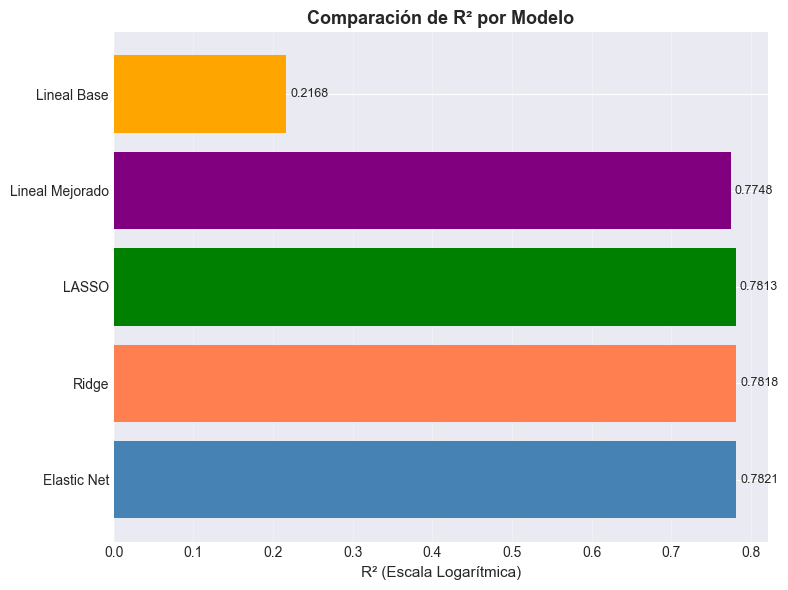

In [868]:
# Crear la figura y el eje para esta única gráfica
fig1, ax1 = plt.subplots(figsize=(8, 6))

# 1. R² Comparison
ax1.barh(summary_table['Modelo'], summary_table['R² (log)'], 
         color=['steelblue', 'coral', 'green', 'purple', 'orange'])
ax1.set_xlabel('R² (Escala Logarítmica)', fontsize=11)
ax1.set_title('Comparación de R² por Modelo', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (model, r2) in enumerate(zip(summary_table['Modelo'], summary_table['R² (log)'])):
    ax1.text(r2 + 0.005, i, f'{r2:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


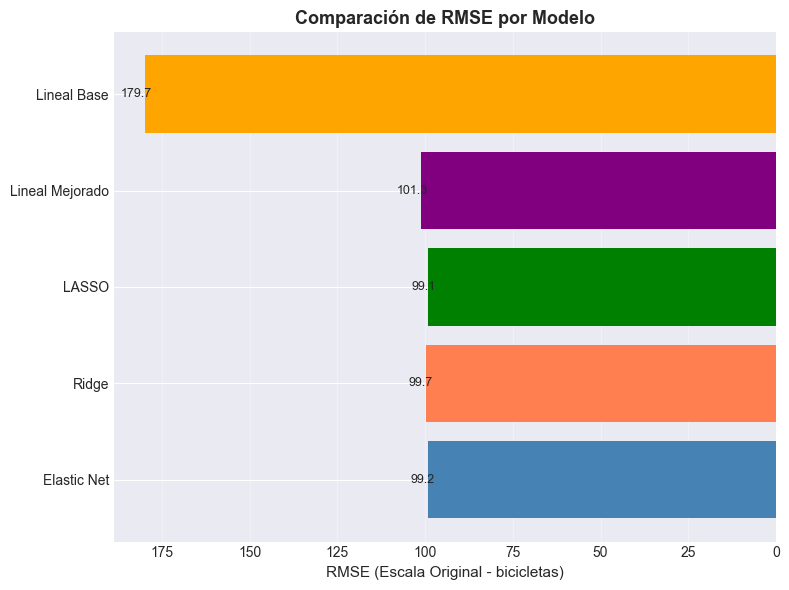

In [869]:
# Crear la figura y el eje para esta única gráfica
fig2, ax2 = plt.subplots(figsize=(8, 6))

# 2. RMSE Comparison (original scale)
ax2.barh(summary_table['Modelo'], summary_table['RMSE (original)'],
         color=['steelblue', 'coral', 'green', 'purple', 'orange'])
ax2.set_xlabel('RMSE (Escala Original - bicicletas)', fontsize=11)
ax2.set_title('Comparación de RMSE por Modelo', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_xaxis()  # Menor es mejor
for i, (model, rmse) in enumerate(zip(summary_table['Modelo'], summary_table['RMSE (original)'])):
    ax2.text(rmse - 2, i, f'{rmse:.1f}', va='center', ha='right', fontsize=9)

plt.tight_layout()
plt.show()

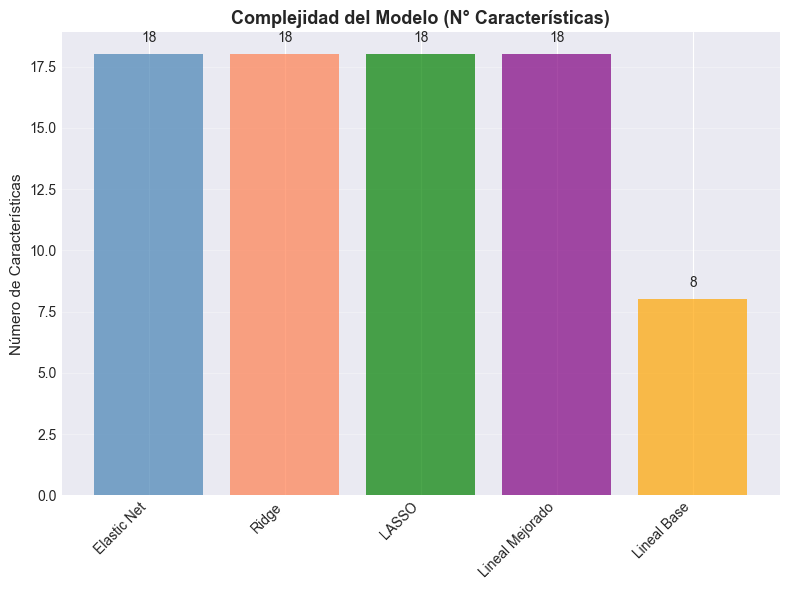

In [870]:
# Crear la figura y el eje para esta única gráfica
fig3, ax3 = plt.subplots(figsize=(8, 6))

# 3. Número de características
ax3.bar(summary_table['Modelo'], summary_table['N° Características'],
        color=['steelblue', 'coral', 'green', 'purple', 'orange'], alpha=0.7)
ax3.set_ylabel('Número de Características', fontsize=11)
ax3.set_title('Complejidad del Modelo (N° Características)', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, (model, n_feat) in enumerate(zip(summary_table['Modelo'], summary_table['N° Características'])):
    ax3.text(i, n_feat + 0.5, str(n_feat), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

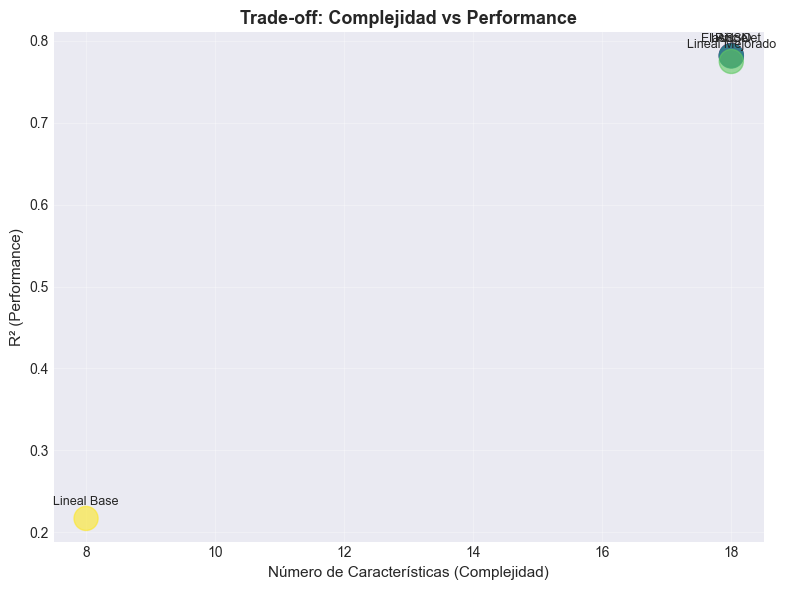

In [873]:

# Crear la figura y el eje para esta única gráfica
fig4, ax4 = plt.subplots(figsize=(8, 6))

# 4. Trade-off: Complejidad vs Performance
ax4.scatter(summary_table['N° Características'], summary_table['R² (log)'],
            s=300, alpha=0.6, c=range(len(summary_table)), cmap='viridis')
for i, model in enumerate(summary_table['Modelo']):
    ax4.annotate(model, 
                 (summary_table.iloc[i]['N° Características'], 
                  summary_table.iloc[i]['R² (log)']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
ax4.set_xlabel('Número de Características (Complejidad)', fontsize=11)
ax4.set_ylabel('R² (Performance)', fontsize=11)
ax4.set_title('Trade-off: Complejidad vs Performance', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###########################################################################
5.3LIMITACIONES DEL ANÁLISIS
#################################################################################

In [1]:
print("""
 PRINCIPALES LIMITACIONES IDENTIFICADAS:

 PROBLEMA DE EXTRAPOLACIÓN TEMPORAL:
• Los modelos fueron entrenados con datos de 2011-2012
• Patrones de movilidad pueden haber cambiado post-pandemia
• Cambios en infraestructura ciclista no capturados
• Comportamientos estacionales pueden variar anualmente

 VARIABLES NO CONSIDERADAS:
• Eventos especiales (conciertos, protestas, maratones)
• Condiciones de tráfico vehicular en tiempo real
• Cierres de estaciones por mantenimiento
• Promociones o cambios en tarifas del sistema
• Apertura de nuevas rutas ciclistas
• Condiciones de contaminación ambiental

 SUPOSICIONES DE MODELOS LINEALES:
• Relaciones lineales entre características y demanda
• Efectos aditivos (no captura interacciones complejas)
• Supuesto de normalidad en residuos (violado en nuestra data)
• Heterocedasticidad no tratada completamente
• No captura patrones no lineales complejos

 GRANULARIDAD TEMPORAL:
• Predicciones por hora pueden ser insuficientes para operaciones en tiempo real
• No considera variaciones intra-hora (ejemplo: picos cada 15 minutos)

FACTORES EXTERNOS:
• Precios del transporte público competitivo
• Cambios en políticas municipales de movilidad
• Factores económicos (desempleo, poder adquisitivo)
""")


 PRINCIPALES LIMITACIONES IDENTIFICADAS:

 PROBLEMA DE EXTRAPOLACIÓN TEMPORAL:
• Los modelos fueron entrenados con datos de 2011-2012
• Patrones de movilidad pueden haber cambiado post-pandemia
• Cambios en infraestructura ciclista no capturados
• Comportamientos estacionales pueden variar anualmente

 VARIABLES NO CONSIDERADAS:
• Eventos especiales (conciertos, protestas, maratones)
• Condiciones de tráfico vehicular en tiempo real
• Cierres de estaciones por mantenimiento
• Promociones o cambios en tarifas del sistema
• Apertura de nuevas rutas ciclistas
• Condiciones de contaminación ambiental

 SUPOSICIONES DE MODELOS LINEALES:
• Relaciones lineales entre características y demanda
• Efectos aditivos (no captura interacciones complejas)
• Supuesto de normalidad en residuos (violado en nuestra data)
• Heterocedasticidad no tratada completamente
• No captura patrones no lineales complejos

 GRANULARIDAD TEMPORAL:
• Predicciones por hora pueden ser insuficientes para operaciones en ti

#######################################################
5.4 MEJORAS PARA FUTUROS ANÁLISIS
########################################################

In [ ]:
print("""
3 MEJORAS CONCRETAS PROPUESTAS:

MODELADO AVANZADO CON MACHINE LEARNING:
• Implementar Gradient Boosting (XGBoost, LightGBM) para capturar no-linealidades
• Usar Redes Neuronales LSTM para patrones temporales secuenciales
• Ensemble methods que combinen múltiples enfoques
• Modelos de series temporales (ARIMA, Prophet) específicos para data temporal

ENRIQUECIMIENTO DE DATOS:
• Integrar datos meteorológicos en tiempo real (API de servicios)
• Incorporar calendario de eventos de la ciudad
• Datos de redes sociales para detectar eventos espontáneos
• Información de tráfico en tiempo real
• Datos de mantenimiento de estaciones
      
ENGINEERING DE CARACTERÍSTICAS AVANZADO:
• Lag features (demanda en horas/días anteriores)
• Rolling statistics (media móvil, desviación estándar móvil)
• Interacciones no lineales entre temperatura y hora
• Características de tendencia estacional (Fourier features)
• Embeddings para variables categóricas temporales

VALIDACIÓN TEMPORAL ROBUSTA:
• Walk-forward validation con múltiples ventanas temporales
• Backtesting con diferentes horizontes de predicción
• Validación en periodos de eventos especiales
• Test de robustez ante cambios estructurales

ANÁLISIS DE INCERTIDUMBRE:
• Intervalos de confianza para predicciones
• Modelado probabilístico (Bayesian methods)
• Análisis de escenarios (qué-pasaria-si)
• Métricas de calidad en diferentes condiciones
""")



3 MEJORAS CONCRETAS PROPUESTAS:

MODELADO AVANZADO CON MACHINE LEARNING:
• Implementar Gradient Boosting (XGBoost, LightGBM) para capturar no-linealidades
• Usar Redes Neuronales LSTM para patrones temporales secuenciales
• Ensemble methods que combinen múltiples enfoques
• Modelos de series temporales (ARIMA, Prophet) específicos para data temporal

ENRIQUECIMIENTO DE DATOS:
• Integrar datos meteorológicos en tiempo real (API de servicios)
• Incorporar calendario de eventos de la ciudad
• Datos de redes sociales para detectar eventos espontáneos
• Información de tráfico en tiempo real
• Datos de mantenimiento de estaciones

ENGINEERING DE CARACTERÍSTICAS AVANZADO:
• Lag features (demanda en horas/días anteriores)
• Rolling statistics (media móvil, desviación estándar móvil)
• Interacciones no lineales entre temperatura y hora
• Características de tendencia estacional (Fourier features)
• Embeddings para variables categóricas temporales

VALIDACIÓN TEMPORAL ROBUSTA:
• Walk-forward val

: 

#################################
5.5 RECOMENDACIONES OPERATIVAS
################################3

In [ ]:

print("""
RECOMENDACIONES PARA EL SISTEMA DE BICICLETAS COMPARTIDAS:

GESTIÓN DE FLOTA BASADA EN PATRONES TEMPORALES:
• Redistribución proactiva durante horas pico (7-9 AM, 5-7 PM)
• Aumentar capacidad en estaciones cercanas a oficinas los días laborales
• Refuerzo en zonas residenciales los fines de semana por la mañana
• Planificación de mantenimiento en horas de baja demanda (madrugada)

ADAPTACIÓN A CONDICIONES CLIMÁTICAS:
• Ajustar inventario según pronóstico de temperatura
• Reducir flota en estaciones exteriores durante lluvia intensa
• Refuerzo en estaciones cubiertas durante mal tiempo
• Protocolos especiales para olas de calor/frío extremo

ENFOQUE EN FACTORES CLAVE IDENTIFICADOS:
• Priorizar estaciones con alta influencia de temperatura
• Monitoreo especial en horas críticas (17h, 8h, 18h)
• Estrategias diferenciadas por tipo de usuario (registrados vs casuales)
• Atención especial a transiciones entre días laborales y fines de semana

MEJORAS EN EXPERIENCIA DE USUARIO:
• App con predicciones de disponibilidad en tiempo real
• Notificaciones proactivas sobre alta demanda en estaciones frecuentadas
• Sistema de reservas para horas pico
• Incentivos para uso en horas valle (descuentos, programas de fidelidad)

MONITOREO Y OPTIMIZACIÓN CONTINUA:
• Dashboard en tiempo real con métricas de demanda
• Sistema de alertas tempranas para desbalances de flota
• Análisis continuo de nuevos patrones emergentes
• Feedback loop con datos de usuarios para mejorar predicciones

PLANIFICACIÓN ESTRATÉGICA:
• Expansión basada en análisis de demanda potencial
• Optimización de ubicación de nuevas estaciones
• Colaboración con planificadores urbanos para infraestructura ciclista
• Integración con otros modos de transporte público
""")